<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

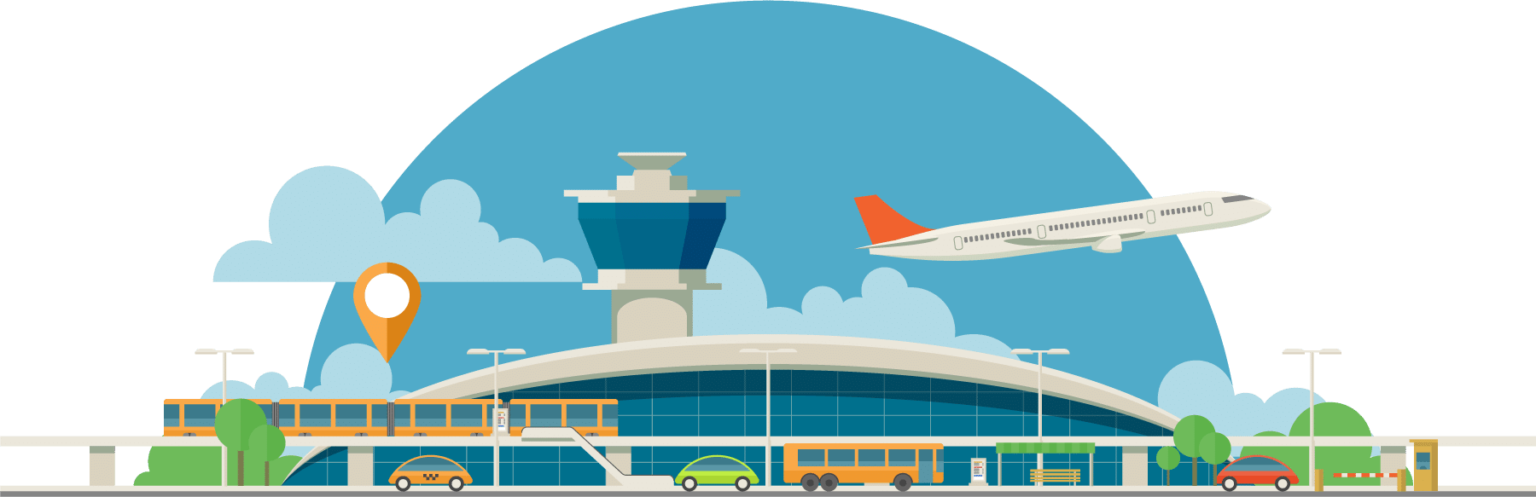

In [5]:
# # # установка всех библиотек, необходимых для выполнения ДЗ

# !pip install catboost
# !pip install mlxtend --upgrade
# !pip install optuna
# !pip install lime
# !pip install shap
# !pip install missingno
# !pip install psycopg2-binary
# !pip install xgboost
# !brew install cmake libomp
# !pip install lightgbm

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [7]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-03-02 11:55:52--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 213.180.193.243
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: «/Users/vitaly/.postgresql/root.crt»

/Users/vitaly/.post 100%[===================>]   3,50K  --.-KB/s    за 0s      

2025-03-02 11:55:52 (1,11 GB/s) - «/Users/vitaly/.postgresql/root.crt» сохранён [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

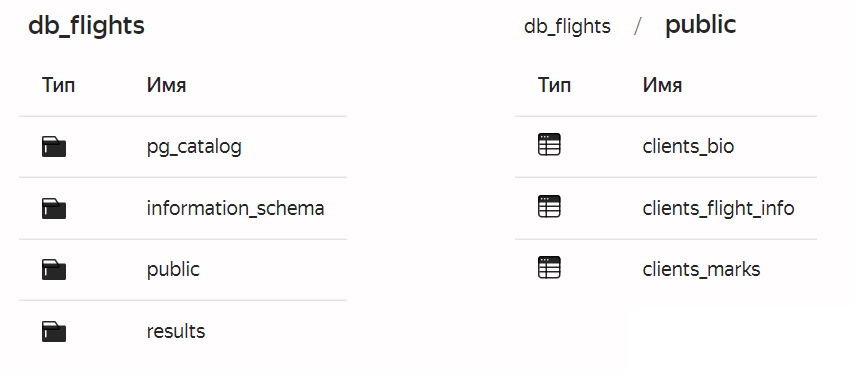



In [8]:
# config
conn = psycopg2.connect(
    dbname="db_flights",
    user="mlhs_student",
    password="mlhs_student",
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port="6432"
)

# Создание курсора
cur = conn.cursor()

sql_query = """
SELECT
  clients_marks.id as client_id,
  *
FROM
  clients_marks
JOIN
  clients_bio
ON
  clients_marks.id = clients_bio.id
JOIN
  clients_flight_info
ON
  clients_marks.id = clients_flight_info.id
"""

# Выполнение SQL-запроса
cur.execute(sql_query)

# Получение результатов запроса
results = cur.fetchall()

# Получение имен столбцов из курсора
columns = [desc[0] for desc in cur.description]

# Преобразование результатов в DataFrame
df = pd.DataFrame(results, columns=columns)

# Закрытие курсора и соединения
cur.close()
conn.close()

In [9]:
df.head(3)

client_id  id Inflight wifi service Departure/Arrival time convenient  \
0          7   7                   3.0                               3.0   
1         13  13                   2.0                               2.0   
2         18  18                   2.0                               5.0   

  Ease of Online booking Gate location Food and drink Online boarding  \
0                    3.0           3.0            5.0             4.0   
1                    2.0           4.0            5.0             2.0   
2                    2.0           1.0            4.0             1.0   

  Seat comfort Inflight entertainment  ...  id  gender   age  id  \
0          5.0                    5.0  ...   7    Male  43.0   7   
1          5.0                    5.0  ...  13    Male  24.0  13   
2          5.0                    5.0  ...  18  Female  61.0  18   

       Customer Type   Type of Travel     class  Flight Distance  \
0     Loyal Customer  Business travel  Business           1963.0   
1  disloyal Customer  Business travel       Eco            453.0   
2     Loyal Customer  Personal Travel       Eco            821.0   

  Departure Delay in Minutes Arrival Delay in Minutes  
0                        0.0                      0.0  
1                       16.0                     30.0  
2                        0.0                      0.0  

[3 rows x 27 columns]

In [10]:
# удалим дублирующиеся столбцы id
df.drop(columns=['id'], axis=1, inplace=True)

In [11]:
df.head(3)

client_id Inflight wifi service Departure/Arrival time convenient  \
0          7                   3.0                               3.0   
1         13                   2.0                               2.0   
2         18                   2.0                               5.0   

  Ease of Online booking Gate location Food and drink Online boarding  \
0                    3.0           3.0            5.0             4.0   
1                    2.0           4.0            5.0             2.0   
2                    2.0           1.0            4.0             1.0   

  Seat comfort Inflight entertainment On-board service  ... cleanliness  \
0          5.0                    5.0              5.0  ...         4.0   
1          5.0                    5.0              2.0  ...         5.0   
2          5.0                    5.0              5.0  ...         1.0   

              satisfaction  gender   age      Customer Type   Type of Travel  \
0                satisfied    Male  43.0     Loyal Customer  Business travel   
1  neutral or dissatisfied    Male  24.0  disloyal Customer  Business travel   
2  neutral or dissatisfied  Female  61.0     Loyal Customer  Personal Travel   

      class Flight Distance Departure Delay in Minutes  \
0  Business          1963.0                        0.0   
1       Eco           453.0                       16.0   
2       Eco           821.0                        0.0   

  Arrival Delay in Minutes  
0                      0.0  
1                     30.0  
2                      0.0  

[3 rows x 24 columns]

In [12]:
# Установка столбца 'id' в качестве индекса
df.set_index('client_id', inplace=True)

In [13]:
df.shape

(129549, 23)

In [14]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [15]:
df.head(1)

Inflight wifi service Departure/Arrival time convenient  \
client_id                                                           
7                           3.0                               3.0   

          Ease of Online booking Gate location Food and drink Online boarding  \
client_id                                                                       
7                            3.0           3.0            5.0             4.0   

          Seat comfort Inflight entertainment On-board service  \
client_id                                                        
7                  5.0                    5.0              5.0   

          Leg room service  ... cleanliness satisfaction gender   age  \
client_id                   ...                                         
7                      5.0  ...         4.0    satisfied   Male  43.0   

            Customer Type   Type of Travel     class Flight Distance  \
client_id                                                              
7          Loyal Customer  Business travel  Business          1963.0   

          Departure Delay in Minutes Arrival Delay in Minutes  
client_id                                                      
7                                0.0                      0.0  

[1 rows x 23 columns]

In [16]:
df.dtypes

Inflight wifi service                object
Departure/Arrival time convenient    object
Ease of Online booking               object
Gate location                        object
Food and drink                       object
Online boarding                      object
Seat comfort                         object
Inflight entertainment               object
On-board service                     object
Leg room service                     object
Baggage handling                     object
Checkin service                      object
Inflight service                     object
cleanliness                          object
satisfaction                         object
gender                               object
age                                  object
Customer Type                        object
Type of Travel                       object
class                                object
Flight Distance                      object
Departure Delay in Minutes           object
Arrival Delay in Minutes        

In [17]:
# типы
df = df.astype({
    'Inflight wifi service': 'float32',
    'Departure/Arrival time convenient': 'float32',
    'Ease of Online booking': 'float32',
    'Gate location': 'float32',
    'Food and drink': 'float32',
    'Online boarding': 'float32',
    'Seat comfort': 'float32',
    'Inflight entertainment': 'float32',
    'On-board service': 'float32',
    'Leg room service': 'float32',
    'Baggage handling': 'float32',
    'Checkin service': 'float32',
    'Inflight service': 'float32',
    'cleanliness': 'float32',
    'Flight Distance': 'float32',
    'age': 'float32',
    'Departure Delay in Minutes': 'float32',
    'Arrival Delay in Minutes': 'float32'
    }
               )

In [18]:
df.dtypes

Inflight wifi service                float32
Departure/Arrival time convenient    float32
Ease of Online booking               float32
Gate location                        float32
Food and drink                       float32
Online boarding                      float32
Seat comfort                         float32
Inflight entertainment               float32
On-board service                     float32
Leg room service                     float32
Baggage handling                     float32
Checkin service                      float32
Inflight service                     float32
cleanliness                          float32
satisfaction                          object
gender                                object
age                                  float32
Customer Type                         object
Type of Travel                        object
class                                 object
Flight Distance                      float32
Departure Delay in Minutes           float32
Arrival De

In [19]:
# пропуски
df.isna().sum()

Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
dtype: int64

In [20]:
df.shape

(129549, 23)

In [21]:
# выбросы
df.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count          129505.000000                      129500.000000   
mean                2.732327                           3.062131   
std                 1.360033                           1.559627   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count           129506.000000  129512.000000   129499.000000    129503.000000   
mean                 2.760721       2.981708        3.208141         3.256782   
std                  1.431049       1.312873        1.357546         1.381888   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 45.000000      36.000000       45.000000        40.000000   

        Seat comfort  Inflight entertainment  On-board service  \
count  129502.000000           129504.000000     129505.000000   
mean        3.445669                3.361232          3.387259   
std         1.349713                1.366908          1.335697   
min         0.000000                0.000000          0.000000   
25%         2.000000                2.000000          2.000000   
50%         4.000000                4.000000          4.000000   
75%         5.000000                4.000000          4.000000   
max        45.000000               45.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count     129503.000000     129501.000000    129507.000000     129486.000000   
mean           3.355976          3.635872         3.309976          3.646927   
std            1.361670          1.222039         1.298827          1.218748   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           40.000000         40.000000        45.000000         40.000000   

         cleanliness            age  Flight Distance  \
count  129512.000000  129234.000000    129455.000000   
mean        3.289780      40.116951      1322.921997   
std         1.347466      20.376129      4517.816406   
min         0.000000       0.000000         0.000000   
25%         2.000000      27.000000       414.000000   
50%         3.000000      40.000000       846.000000   
75%         4.000000      51.000000      1744.000000   
max        45.000000     621.000000    379620.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               129442.000000             129042.000000  
mean                    15.809027                 16.656500  
std                     93.276886                109.285072  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                  22227.000000              14006.000000

Заметны странные моменты:


1.   в стобце возраст (**age**) максимальный - 621, что невозможно
2.   Максимальная длина полета (**Flight Distance**) 379620 км, хотя максимально возможная - это 41467 (по интернету)
3.   Задержки прибытия и отбытия (**Departure Delay in Minutes**, **Arrival Delay in Minutes**) очень большие, что подозрительно

Все это могут быть выбросы

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

In [22]:
!pip install missingno

zsh:1: command not found: pip


In [23]:
import missingno as msno

<Axes: >

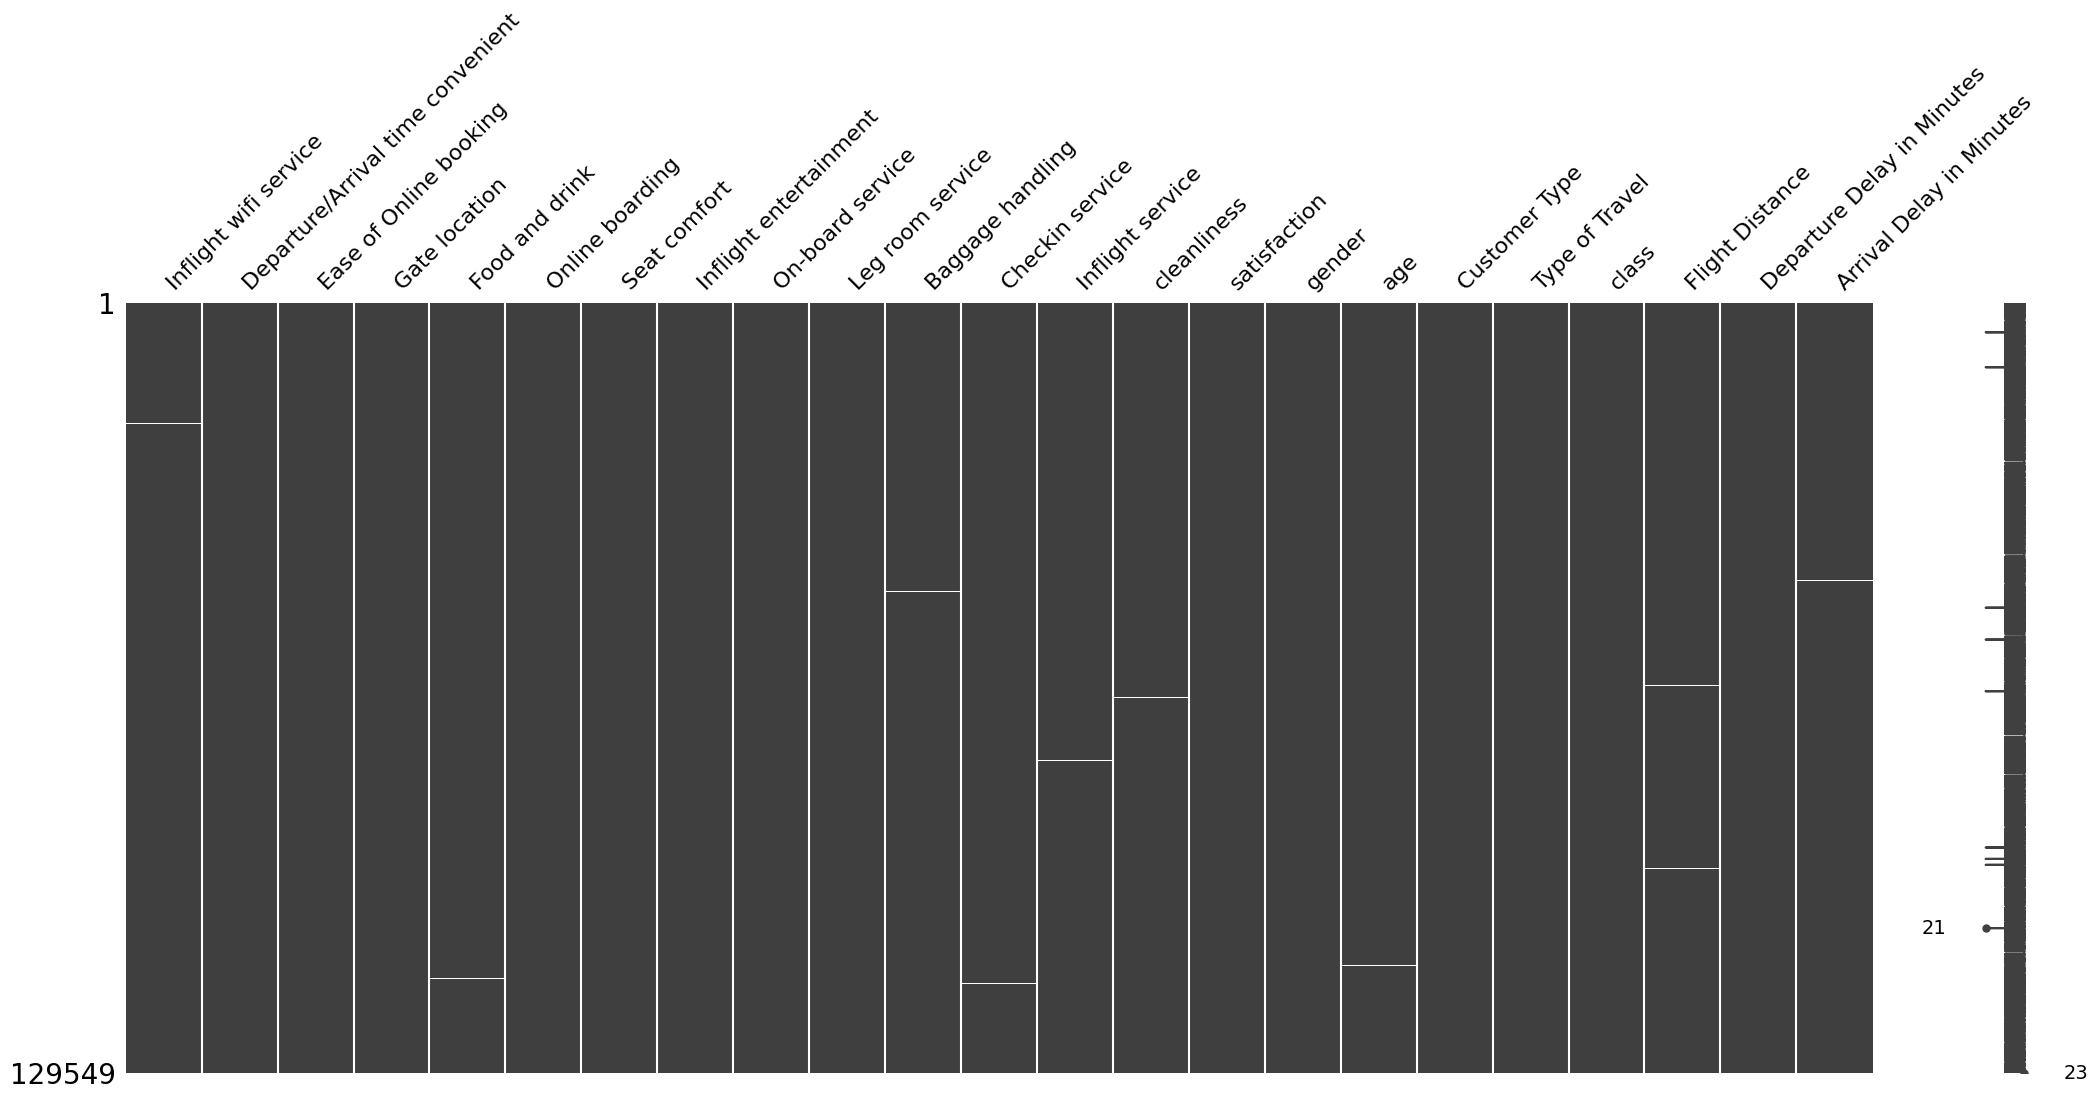

In [24]:
# Ваш код ниже
msno.matrix(df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

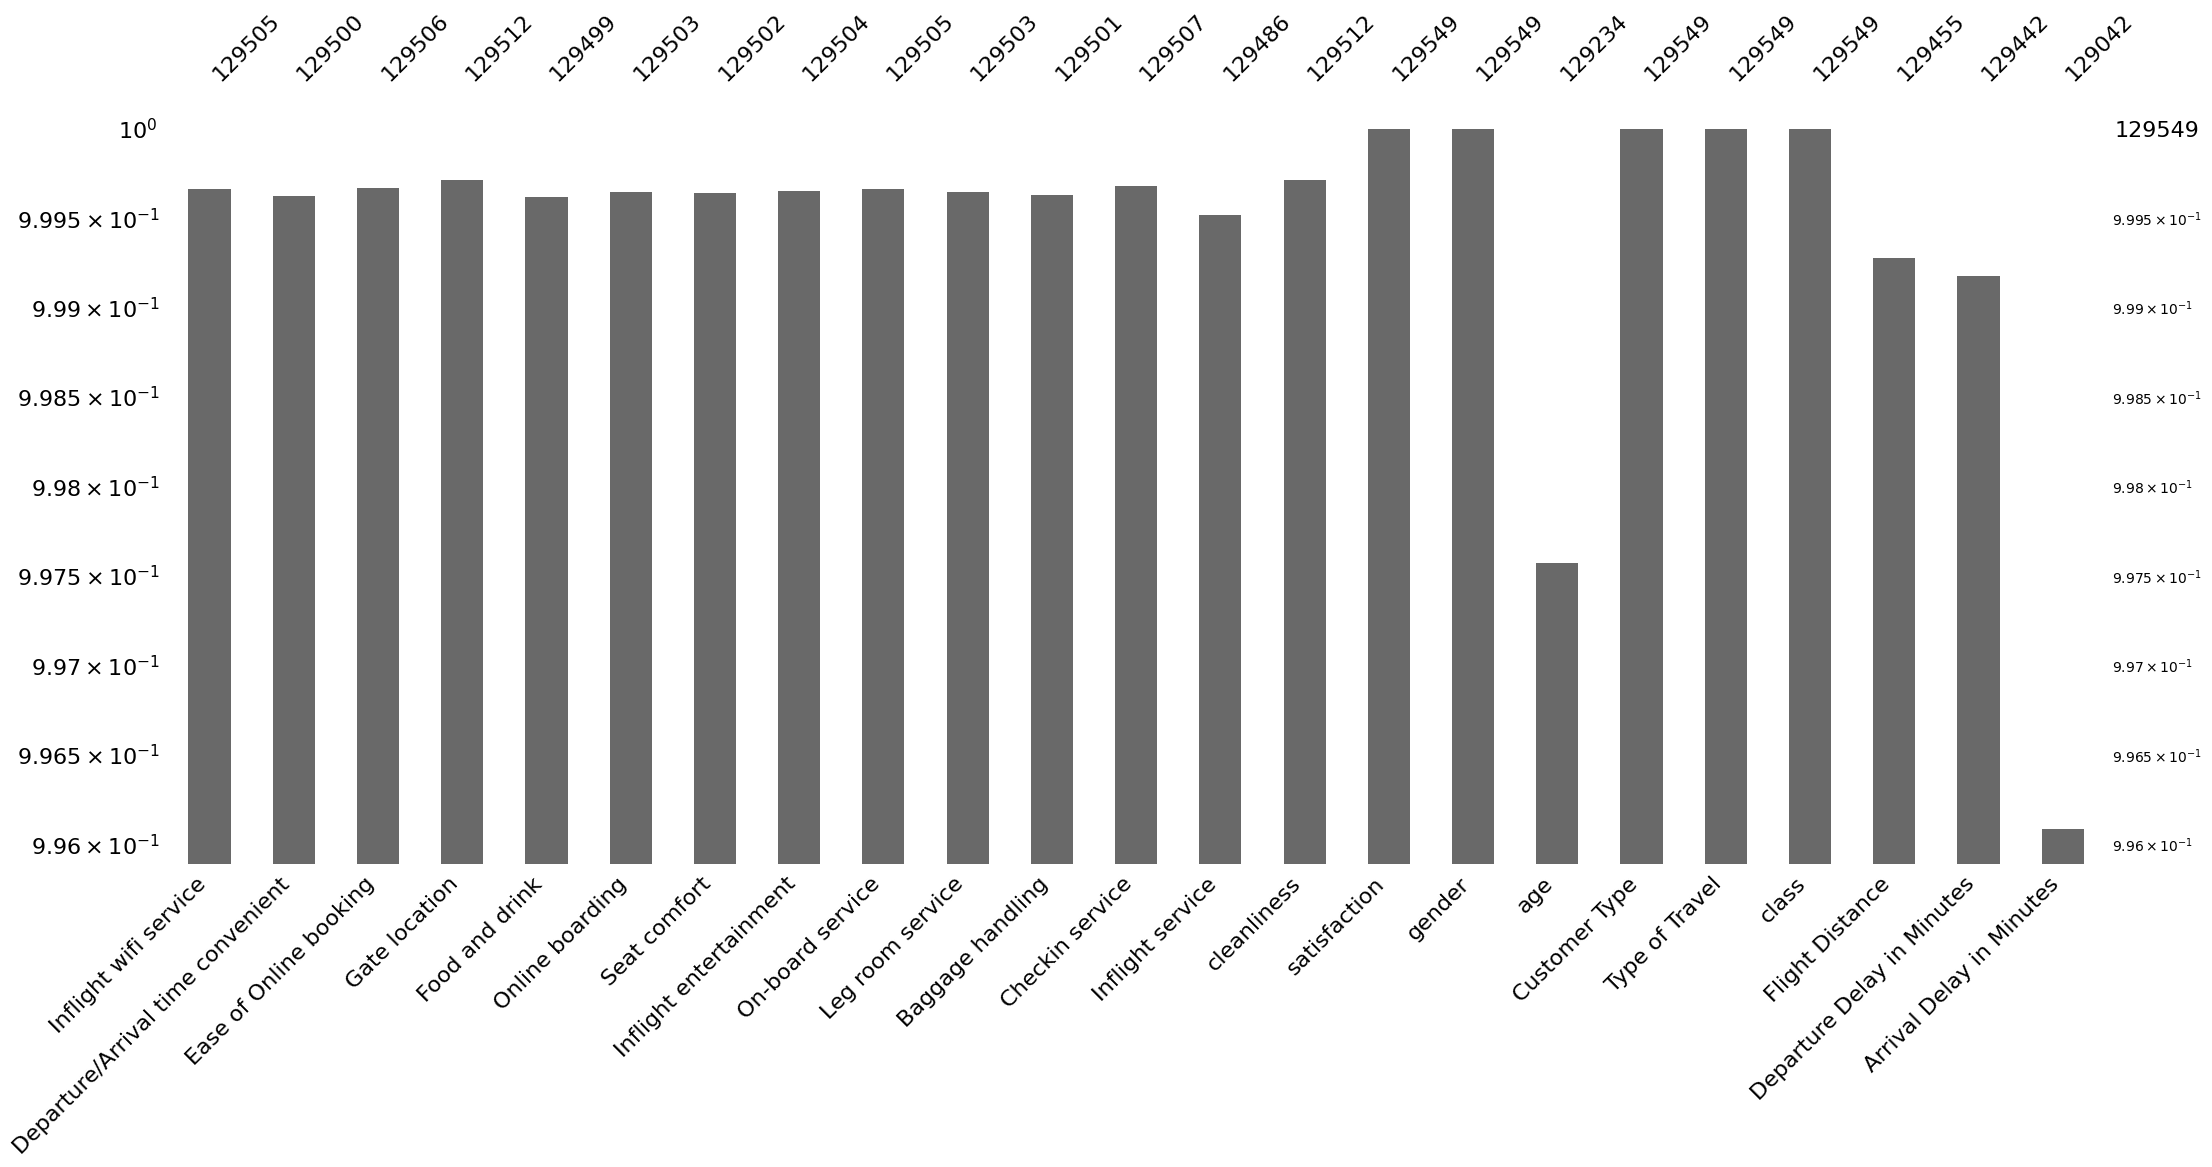

In [25]:
# Ваш код ниже
msno.bar(df,
         log=True
        )

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [26]:
df_train = df[df.satisfaction != '-']
df_train

Inflight wifi service  Departure/Arrival time convenient  \
client_id                                                             
7                            3.0                                3.0   
13                           2.0                                2.0   
18                           2.0                                5.0   
31                           2.0                                2.0   
39                           3.0                                3.0   
...                          ...                                ...   
129831                       1.0                                3.0   
129837                       2.0                                4.0   
129838                       3.0                                5.0   
129839                       2.0                                4.0   
129846                       2.0                                5.0   

           Ease of Online booking  Gate location  Food and drink  \
client_id                                                          
7                             3.0            3.0             5.0   
13                            2.0            4.0             5.0   
18                            2.0            1.0             4.0   
31                            2.0            1.0             2.0   
39                            3.0            3.0             4.0   
...                           ...            ...             ...   
129831                        1.0            5.0             3.0   
129837                        2.0            3.0             2.0   
129838                        3.0            4.0             2.0   
129839                        2.0            3.0             3.0   
129846                        2.0            3.0             5.0   

           Online boarding  Seat comfort  Inflight entertainment  \
client_id                                                          
7                      4.0           5.0                     5.0   
13                     2.0           5.0                     5.0   
18                     1.0           5.0                     5.0   
31                     2.0           2.0                     2.0   
39                     5.0           4.0                     4.0   
...                    ...           ...                     ...   
129831                 1.0           3.0                     3.0   
129837                 5.0           5.0                     5.0   
129838                 5.0           5.0                     3.0   
129839                 2.0           3.0                     3.0   
129846                 2.0           5.0                     5.0   

           On-board service  Leg room service  ...  cleanliness  \
client_id                                      ...                
7                       5.0               5.0  ...          4.0   
13                      2.0               4.0  ...          5.0   
18                      5.0               2.0  ...          1.0   
31                      4.0               5.0  ...          2.0   
39                      4.0               4.0  ...          5.0   
...                     ...               ...  ...          ...   
129831                  1.0               1.0  ...          3.0   
129837                  2.0               4.0  ...          5.0   
129838                  3.0               3.0  ...          4.0   
129839                  4.0               5.0  ...          3.0   
129846                  4.0               2.0  ...          5.0   

                      satisfaction  gender   age      Customer Type  \
client_id                                                             
7                        satisfied    Male  43.0     Loyal Customer   
13         neutral or dissatisfied    Male  24.0  disloyal Customer   
18         neutral or dissatisfied  Female  61.0     Loyal Customer   
31         neutral or dissatisfied    Male  35.0  disloyal Customer   
39                 

In [27]:
assert df_train.shape == (103_644, 23)

In [28]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

Inflight wifi service  Departure/Arrival time convenient  \
client_id                                                             
55                           1.0                                1.0   
79                           5.0                                4.0   
126                          2.0                                5.0   
199                          4.0                                4.0   
263                          1.0                                2.0   
...                          ...                                ...   
129750                       4.0                                3.0   
129771                       3.0                                4.0   
129798                       2.0                                4.0   
129868                       3.0                                4.0   
129876                       4.0                                4.0   

           Ease of Online booking  Gate location  Food and drink  \
client_id                                                          
55                            1.0            1.0             1.0   
79                            0.0            3.0             4.0   
126                           2.0            4.0             5.0   
199                           4.0            4.0             2.0   
263                           1.0            3.0             2.0   
...                           ...            ...             ...   
129750                        3.0            3.0             4.0   
129771                        3.0            3.0             1.0   
129798                        2.0            2.0             3.0   
129868                        4.0            4.0             4.0   
129876                        4.0            2.0             4.0   

           Online boarding  Seat comfort  Inflight entertainment  \
client_id                                                          
55                     3.0           3.0                     3.0   
79                     4.0           4.0                     3.0   
126                    2.0           5.0                     5.0   
199                    4.0           5.0                     4.0   
263                    3.0           3.0                     2.0   
...                    ...           ...                     ...   
129750                 5.0           4.0                     4.0   
129771                 3.0           5.0                     1.0   
129798                 5.0           5.0                     4.0   
129868                 3.0           4.0                     4.0   
129876                 4.0           1.0                     4.0   

           On-board service  Leg room service  ...  Inflight service  \
client_id                                      ...                     
55                      3.0               3.0  ...               3.0   
79                      3.0               0.0  ...               3.0   
126                     3.0               5.0  ...               5.0   
199                     4.0               4.0  ...               4.0   
263                     2.0               1.0  ...               2.0   
...                     ...               ...  ...               ...   
129750                  4.0               5.0  ...               3.0   
129771                  4.0               2.0  ...               4.0   
129798                  4.0               2.0  ...               4.0   
129868                  2.0               5.0  ...               4.0   
129876                  5.0               4.0  ...               5.0   

           cleanliness  gender   age   Customer Type   Type of Travel  \
client_id                                                               
55                 2.0    Male  36.0  Loyal Customer  Business travel   
79                 5.0  Female  70.0  Loyal Customer  Personal Travel   
126                5.0    Male  66.0  Loyal Customer  Personal Travel   
199            

In [29]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [31]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [32]:
# Ваш код ниже
X_train_filled = X_train.fillna(X_train.mode().iloc[0])
X_train_filled.isna().sum().any()

False

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [33]:
# числовые
X_train_filled.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count           72550.000000                       72550.000000   
mean                2.733687                           3.065017   
std                 1.362172                           1.552254   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72550.000000   72550.000000    72550.000000     72550.000000   
mean                 2.761006       2.982688        3.209318         3.256513   
std                  1.414842       1.316648        1.349963         1.372739   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72550.000000            72550.000000      72550.000000   
mean       3.445665                3.362150          3.383101   
std        1.346077                1.360862          1.333758   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72550.000000      72550.000000     72550.000000      72550.000000   
mean           3.352364          3.630255         3.309056          3.640234   
std            1.360180          1.227853         1.293114          1.215114   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness           age  Flight Distance  \
count  72550.000000  72550.000000     72550.000000   
mean       3.291178     40.098854      1329.018311   
std        1.343302     20.658195      4764.369629   
min        0.000000      0.000000         0.000000   
25%        2.000000     27.000000       413.000000   
50%        3.000000     40.000000       844.000000   
75%        4.000000     51.000000      1744.000000   
max       45.000000    544.000000    379620.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count                72550.000000              72550.000000  
mean                    15.859366                 16.645967  
std                     70.861938                 97.990295  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   9282.000000              11760.000000

In [34]:
# категориальные
X_train_filled.describe(include=['object'])

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               3                3         4
top     Female  Loyal Customer  Business travel  Business
freq     36816           59354            49984     34727

Выводы:

По числовым признакам я уже дал комментарии ранее, а по категориальным:



1.   класс пола сбалансирован
2.   большая часть клиентов лояльна
3.   большая часть поездок носит бизнес характер
4.   большая часть перелетов была совершена в классе бизнес



### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [ ]:
X_train_numeric_columns = X_train_filled.select_dtypes(include=[np.number]).columns

X_train_quantiles = X_train_filled[X_train_numeric_columns].quantile(0.996)

X_train_mask = (X_train_filled[X_train_numeric_columns] <= X_train_quantiles).all(axis=1)
X_train_filtered = X_train_filled[X_train_mask]

X_train_filtered.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count           71395.000000                       71395.000000   
mean                2.729827                           3.061895   
std                 1.329804                           1.524972   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                 5.000000                           5.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            71395.000000   71395.000000    71395.000000     71395.000000   
mean                 2.757168       2.977744        3.206401         3.252343   
std                  1.399303       1.277994        1.329861         1.349783   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                  5.000000       5.000000        5.000000         5.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  71395.000000            71395.000000      71395.000000   
mean       3.440885                3.358232          3.379102   
std        1.317559                1.334222          1.289210   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max        5.000000                5.000000          5.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      71395.000000      71395.000000     71395.000000      71395.000000   
mean           3.344842          3.625310         3.304895          3.637608   
std            1.317095          1.185203         1.267415          1.177825   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max            5.000000          5.000000         5.000000          5.000000   

        cleanliness           age  Flight Distance  \
count  71395.000000  71395.000000     71395.000000   
mean       3.286631     39.379677      1180.327026   
std        1.312964     15.103008       987.084961   
min        0.000000      0.000000         0.000000   
25%        2.000000     27.000000       409.000000   
50%        3.000000     40.000000       837.000000   
75%        4.000000     51.000000      1729.000000   
max        5.000000     80.000000      3980.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count                71395.000000              71395.000000  
mean                    13.560081                 13.845101  
std                     30.672384                 31.043846  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                    265.000000                270.000000

In [ ]:
X_val_numeric_columns = X_val.select_dtypes(include=[np.number]).columns
X_val_quantiles = X_val[X_val_numeric_columns].quantile(0.996)

X_val_mask = (X_val[X_val_numeric_columns] <= X_val_quantiles).all(axis=1)
X_val_filtered = X_val[X_val_mask]

X_val_filtered.describe()

Inflight wifi service  Departure/Arrival time convenient  \
count           30196.000000                       30196.000000   
mean                2.725394                           3.056829   
std                 1.323723                           1.527498   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                 5.000000                           5.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            30196.000000   30196.000000    30196.000000     30196.000000   
mean                 2.753146       2.974732        3.189826         3.238707   
std                  1.397084       1.275467        1.328879         1.350724   
min                  0.000000       1.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                  5.000000       5.000000        5.000000         5.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  30196.000000            30196.000000      30196.000000   
mean       3.431680                3.355676          3.389820   
std        1.323211                1.331693          1.284841   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max        5.000000                5.000000          5.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      30196.000000      30196.000000     30196.000000      30196.000000   
mean           3.361339          3.645019         3.299642          3.654590   
std            1.313166          1.171924         1.260989          1.167498   
min            0.000000          1.000000         0.000000          1.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max            5.000000          5.000000         5.000000          5.000000   

        cleanliness           age  Flight Distance  \
count  30196.000000  30196.000000     30196.000000   
mean       3.280236     39.330837      1184.180298   
std        1.310442     15.187512       990.048523   
min        0.000000      0.000000         0.000000   
25%        2.000000     27.000000       416.000000   
50%        3.000000     40.000000       838.000000   
75%        4.000000     51.000000      1737.000000   
max        5.000000     80.000000      3977.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count                30196.000000              30196.000000  
mean                    13.287721                 13.679163  
std                     30.570955                 31.008371  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 12.000000  
max                    264.000000                263.000000

In [38]:
X_val_filtered.shape

(30196, 22)

In [39]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [40]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [41]:
# столбец class никуда не попал - добавим руками
categorical_cols.append('class')

In [42]:
categorical_cols

['satisfaction', 'gender', 'Customer Type', 'Type of Travel', 'class']

In [43]:
# assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [44]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    columns = list(cols) 
    num_plots = len(cols)
    num_rows = (num_plots + 1) // 2

    plt.figure(figsize=(15, 5 * num_rows))

    for i, column in enumerate(columns, 1):
        if column in df.columns:
            plt.subplot(num_rows, 2, i) 
            sns.countplot(x=column, data=df, hue=y) 
            plt.title(f'Countplot для столбца: {column}') 
            plt.xlabel(column)
            plt.ylabel('Количество') 
        else:
            print(f"Столбец '{column}' не найден в датафрейме.")

    plt.tight_layout() 
    plt.show()

In [45]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    columns = list(cols) 
    num_plots = len(columns)
    num_rows = num_plots

    plt.figure(figsize=(15, 5 * num_rows))  

    for i, column in enumerate(columns, 1):
        if column in df.columns:
            # Гистограмма распределения
            plt.subplot(num_rows, 2, 2 * i - 1) 
            sns.histplot(df[column], kde=True) 
            plt.title(f'Гистограмма распределения для столбца: {column}')  
            plt.xlabel(column)  
            plt.ylabel('Частота')  

            # Boxplot
            plt.subplot(num_rows, 2, 2 * i)  
            sns.boxplot(x=df[column], hue=y) 
            plt.title(f'Boxplot для столбца: {column}') 
            plt.xlabel(column)
        else:
            print(f"Столбец '{column}' не найден в датафрейме.")

    plt.tight_layout() 
    plt.show()

In [46]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    columns = list(cols) 
    num_plots = len(cols)
    num_rows = (num_plots + 1) // 2

    plt.figure(figsize=(15, 5 * num_rows))

    for i, column in enumerate(columns, 1):
        if column in df.columns:
            plt.subplot(num_rows, 2, i)  
            sns.countplot(x=column, data=df, hue=y) 
            plt.title(f'Countplot для столбца: {column}')
            plt.xlabel(column) 
            plt.ylabel('Количество') 
        else:
            print(f"Столбец '{column}' не найден в датафрейме.")

    plt.tight_layout()  
    plt.show() 

Отрисовка.

Столбец 'satisfaction' не найден в датафрейме.


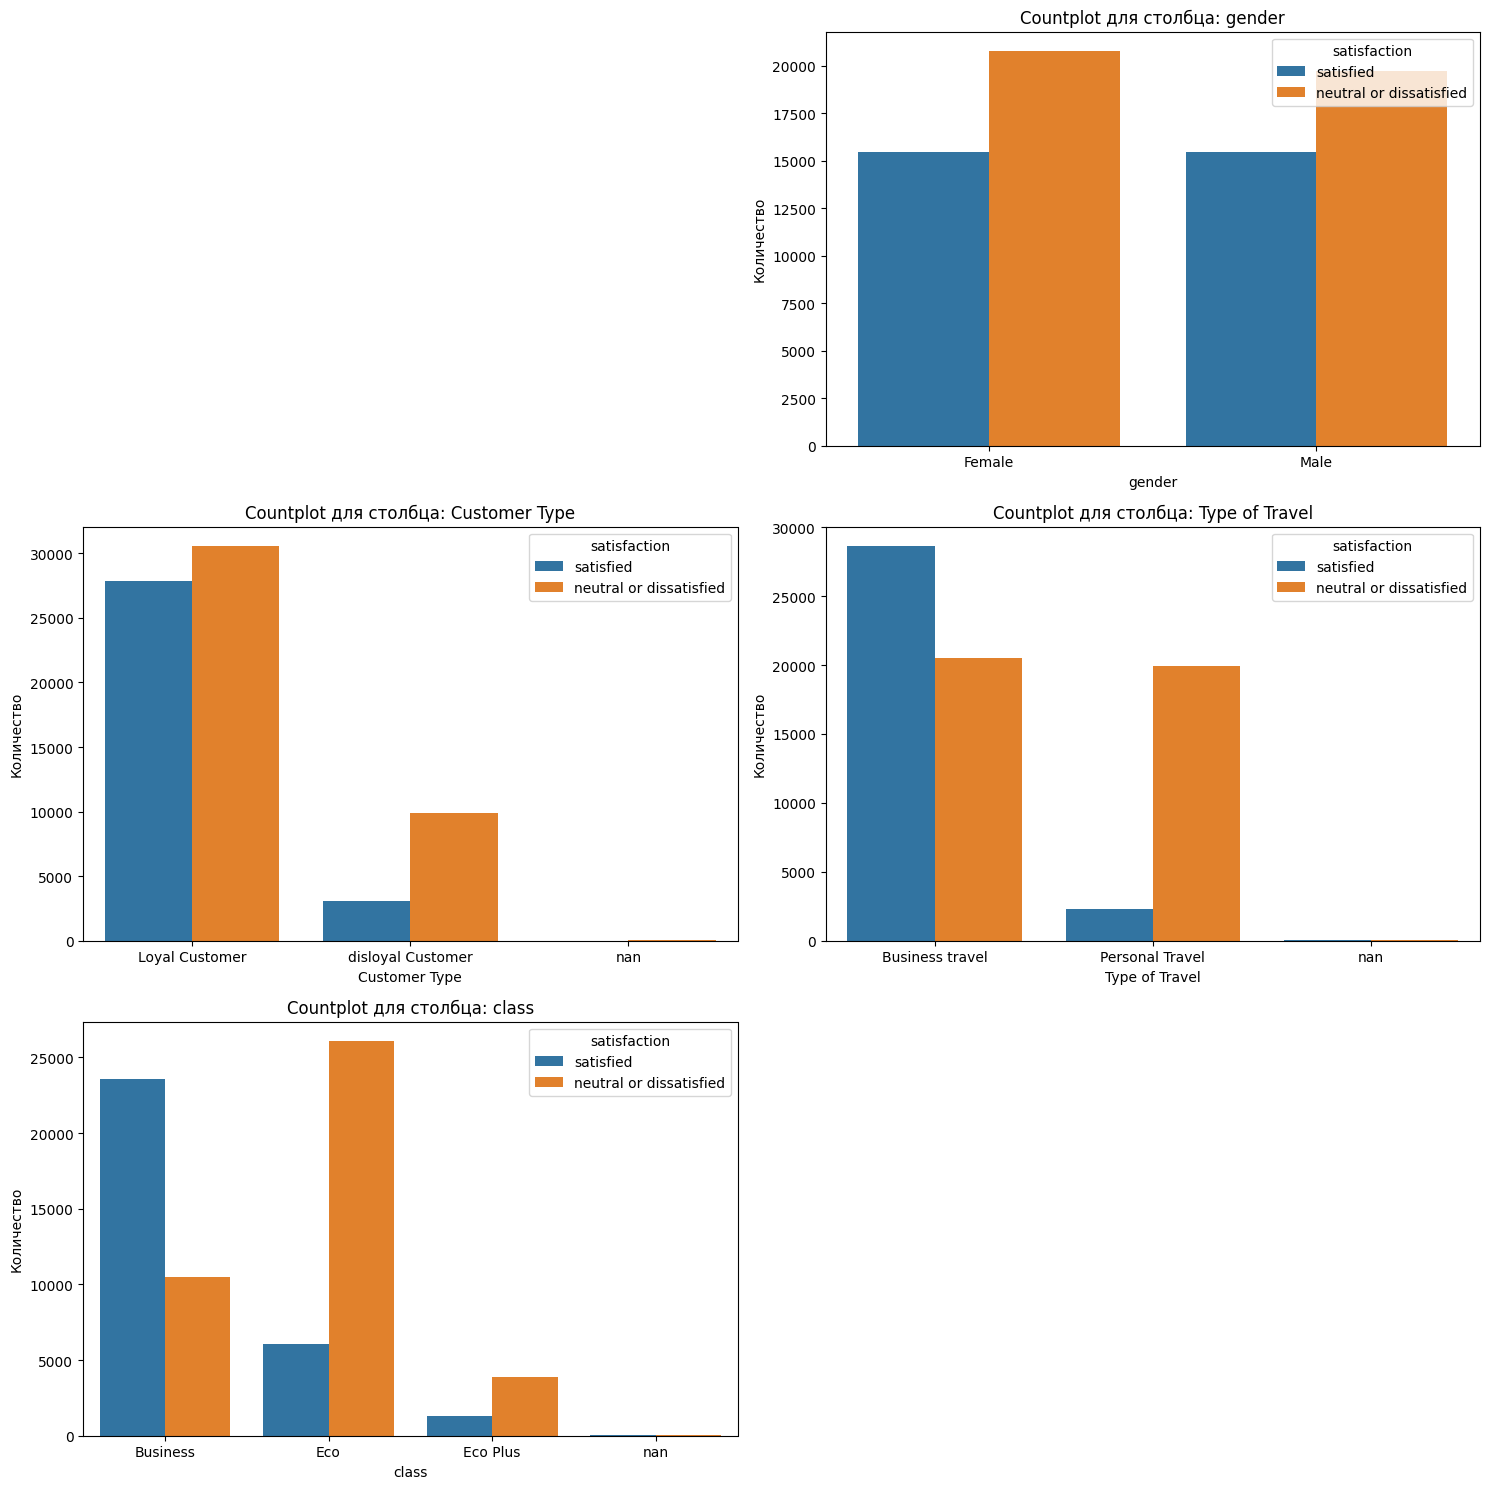

In [47]:
plot_categorical(categorical_cols, X_train_filtered, y_train)

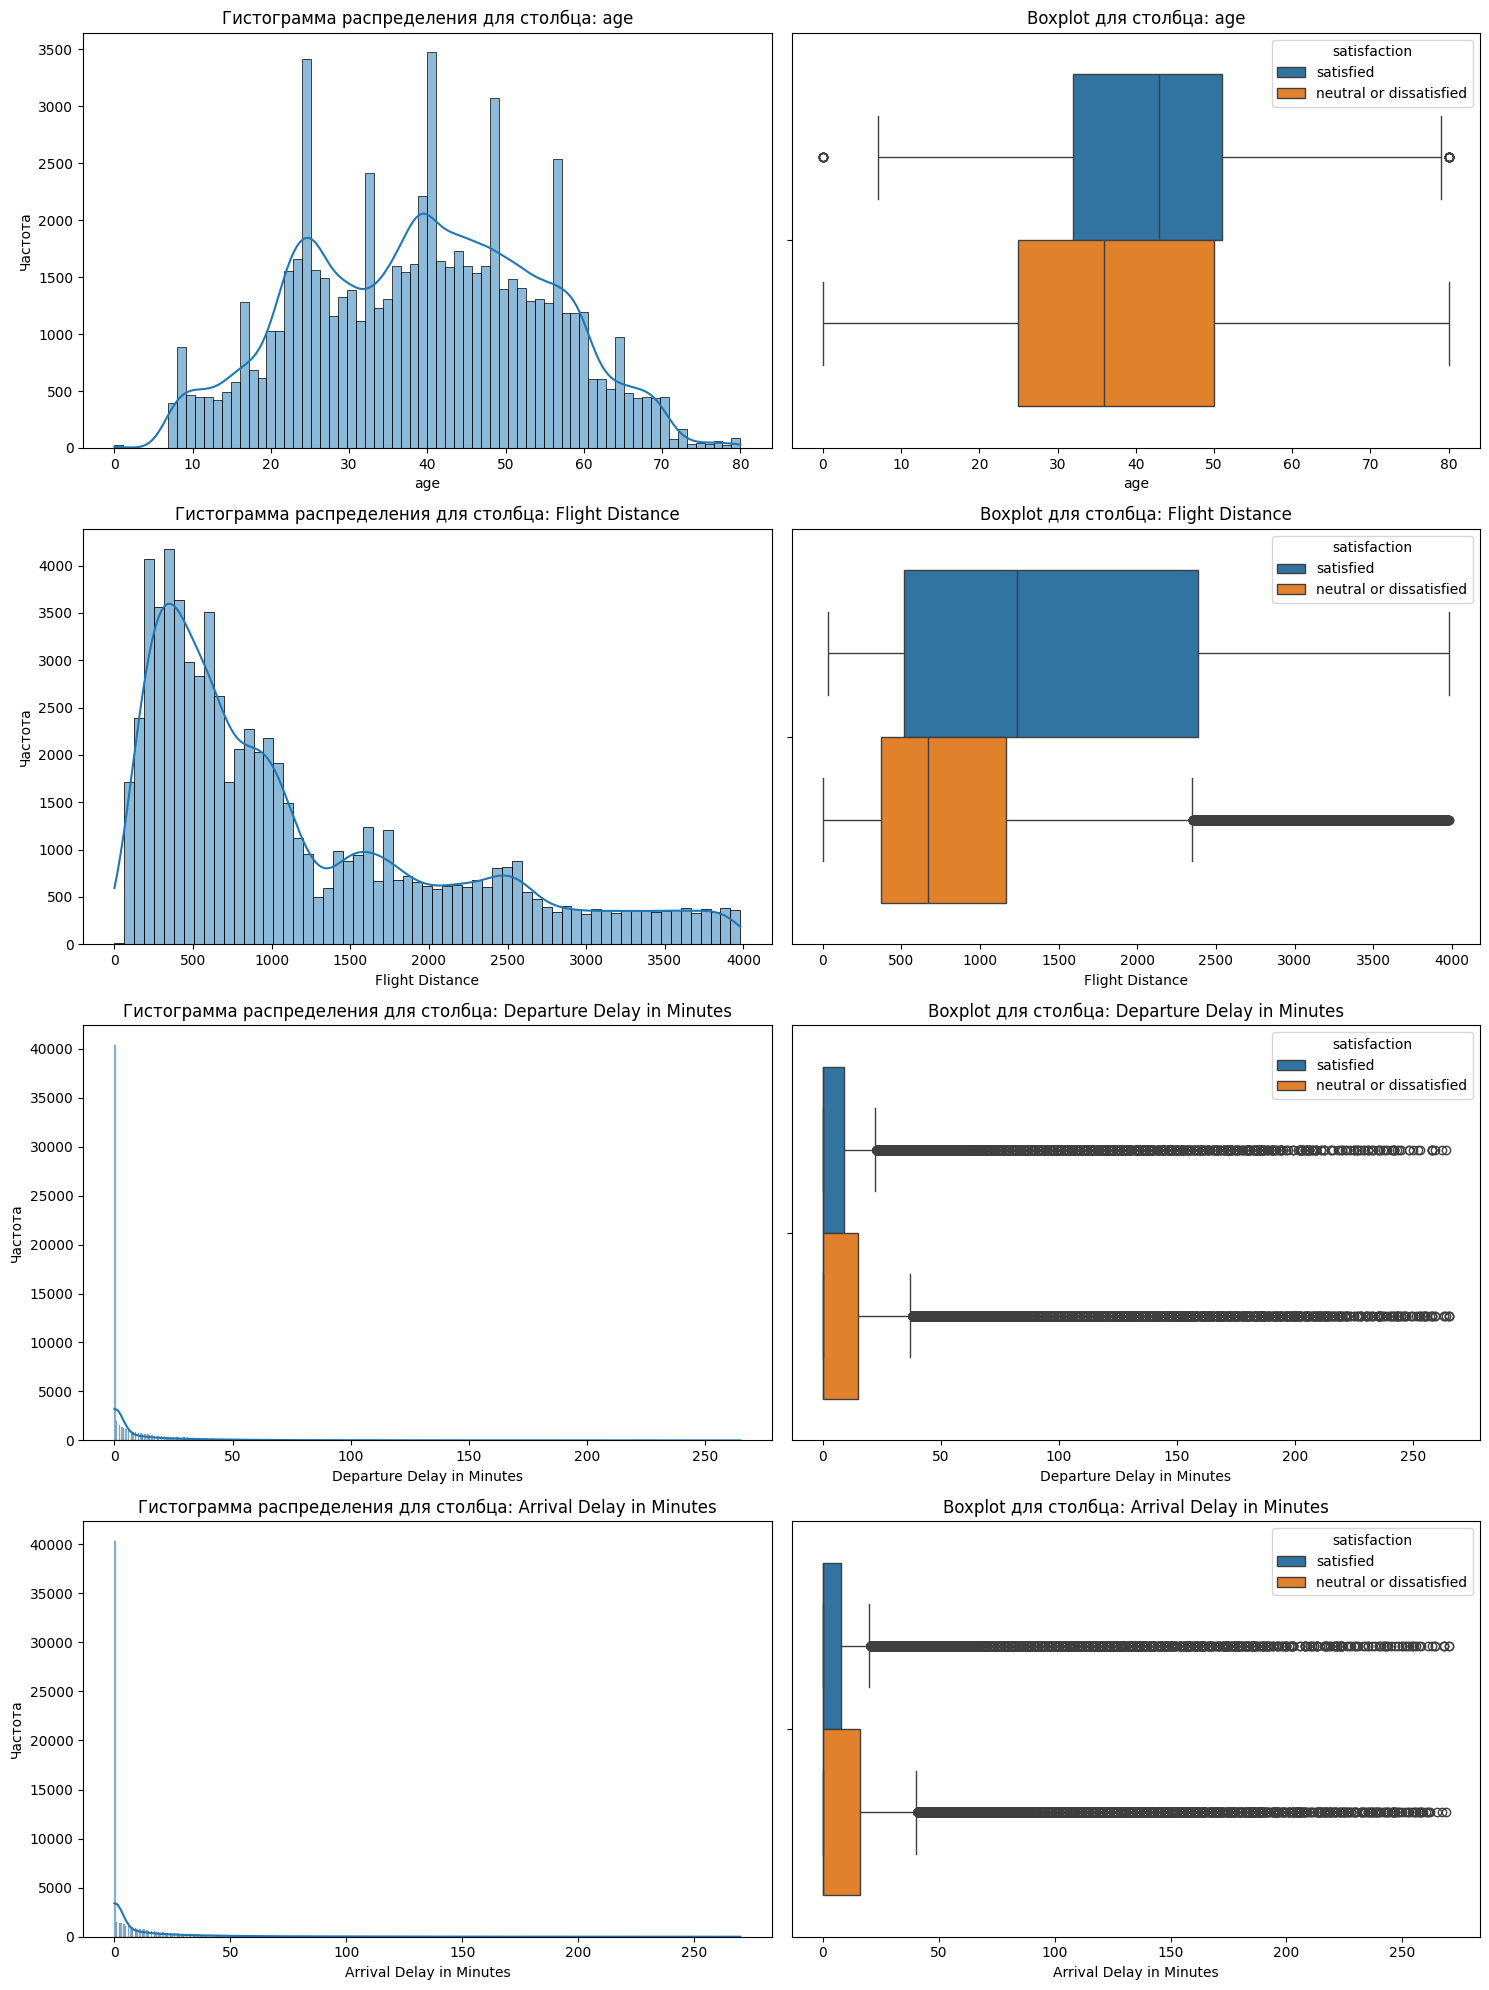

In [48]:
plot_continuous(continuous_cols, X_train_filtered, y_train)

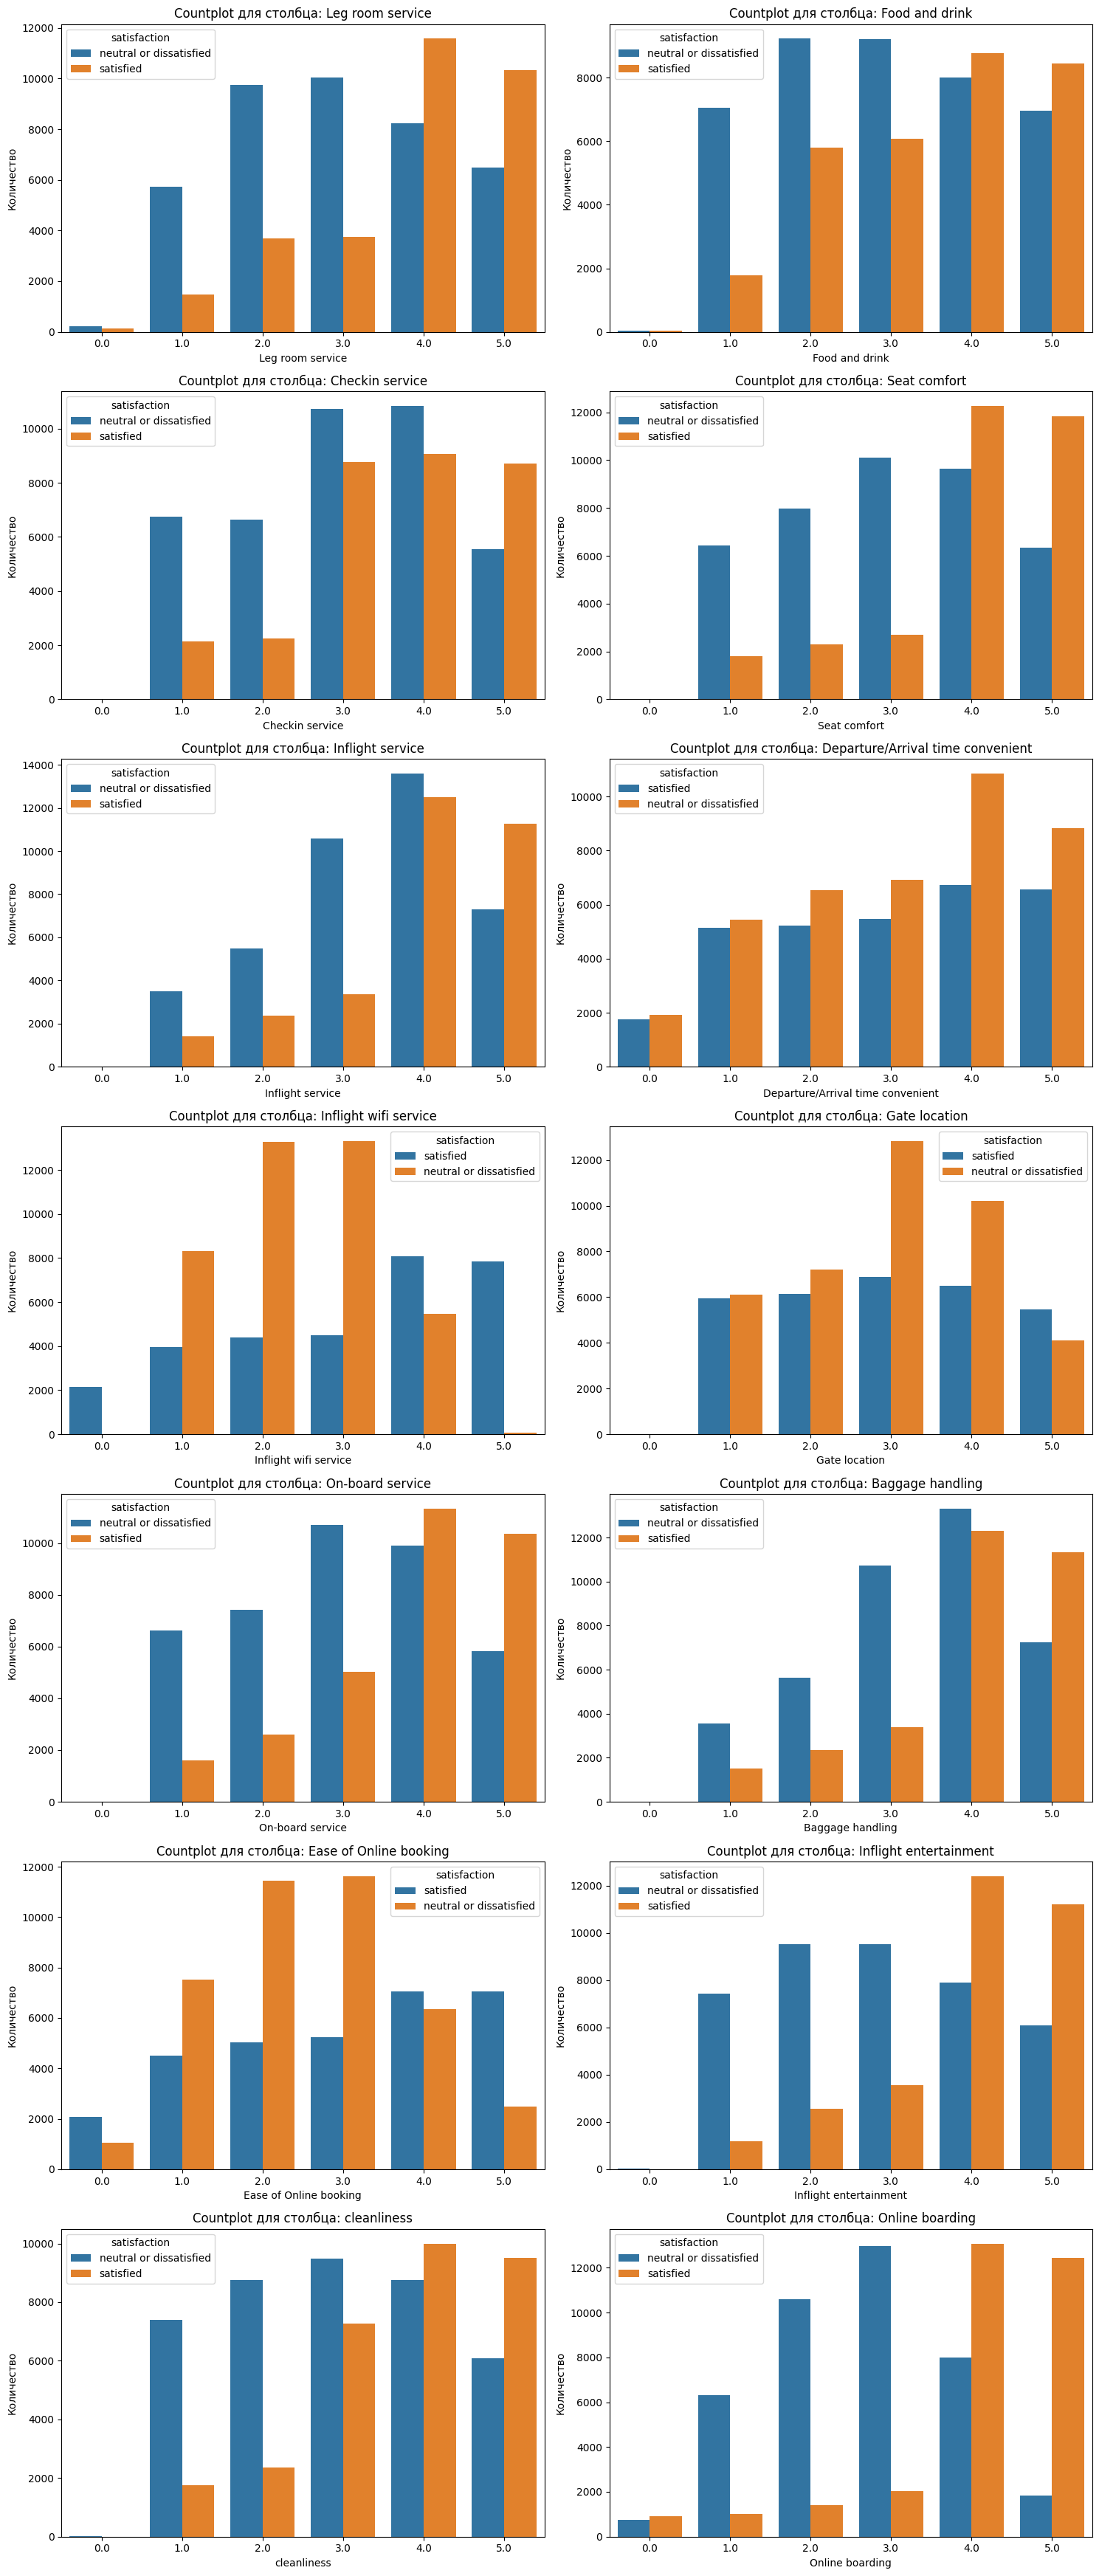

In [49]:
plot_ordinal(ordinal_cols, X_train_filtered, y_train)

<Axes: xlabel='client_id', ylabel='satisfaction'>

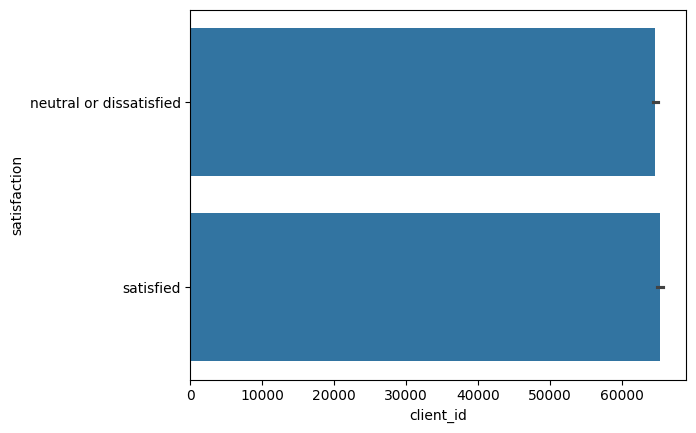

In [50]:
# visualize y_train
sns.barplot(y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Смысл:
1) Удовлетворенные клиенты преобладают в бизнес сегменте (путешествуют бизнес-классом, по классу больше относятся к бизнесу)
2) Удовлетворенные клиенты старше (отличается медианный возраст), они летают на большие расстояния и у их рейсов меньше время для двух видов задержек

Распределения:
Неравномерны по типу клиента, классу поездки

Классы:
несбалансированы по типу поездки, классу поездки, и, закономерно, по оценкам.
Сами по себе классы сбалансированы.
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [117]:
# Ваш код ниже

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [124]:
X_train_filtered_log = X_train_filtered.copy()
X_train_filtered_log['Departure Delay in Minutes log'] = np.log(X_train_filtered_log['Departure Delay in Minutes'])
X_train_filtered_log['Arrival Delay in Minutes log'] = np.log(X_train_filtered_log['Arrival Delay in Minutes'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Построение.

In [128]:
continuous_cols.append('Departure Delay in Minutes log')
continuous_cols.append('Arrival Delay in Minutes log')

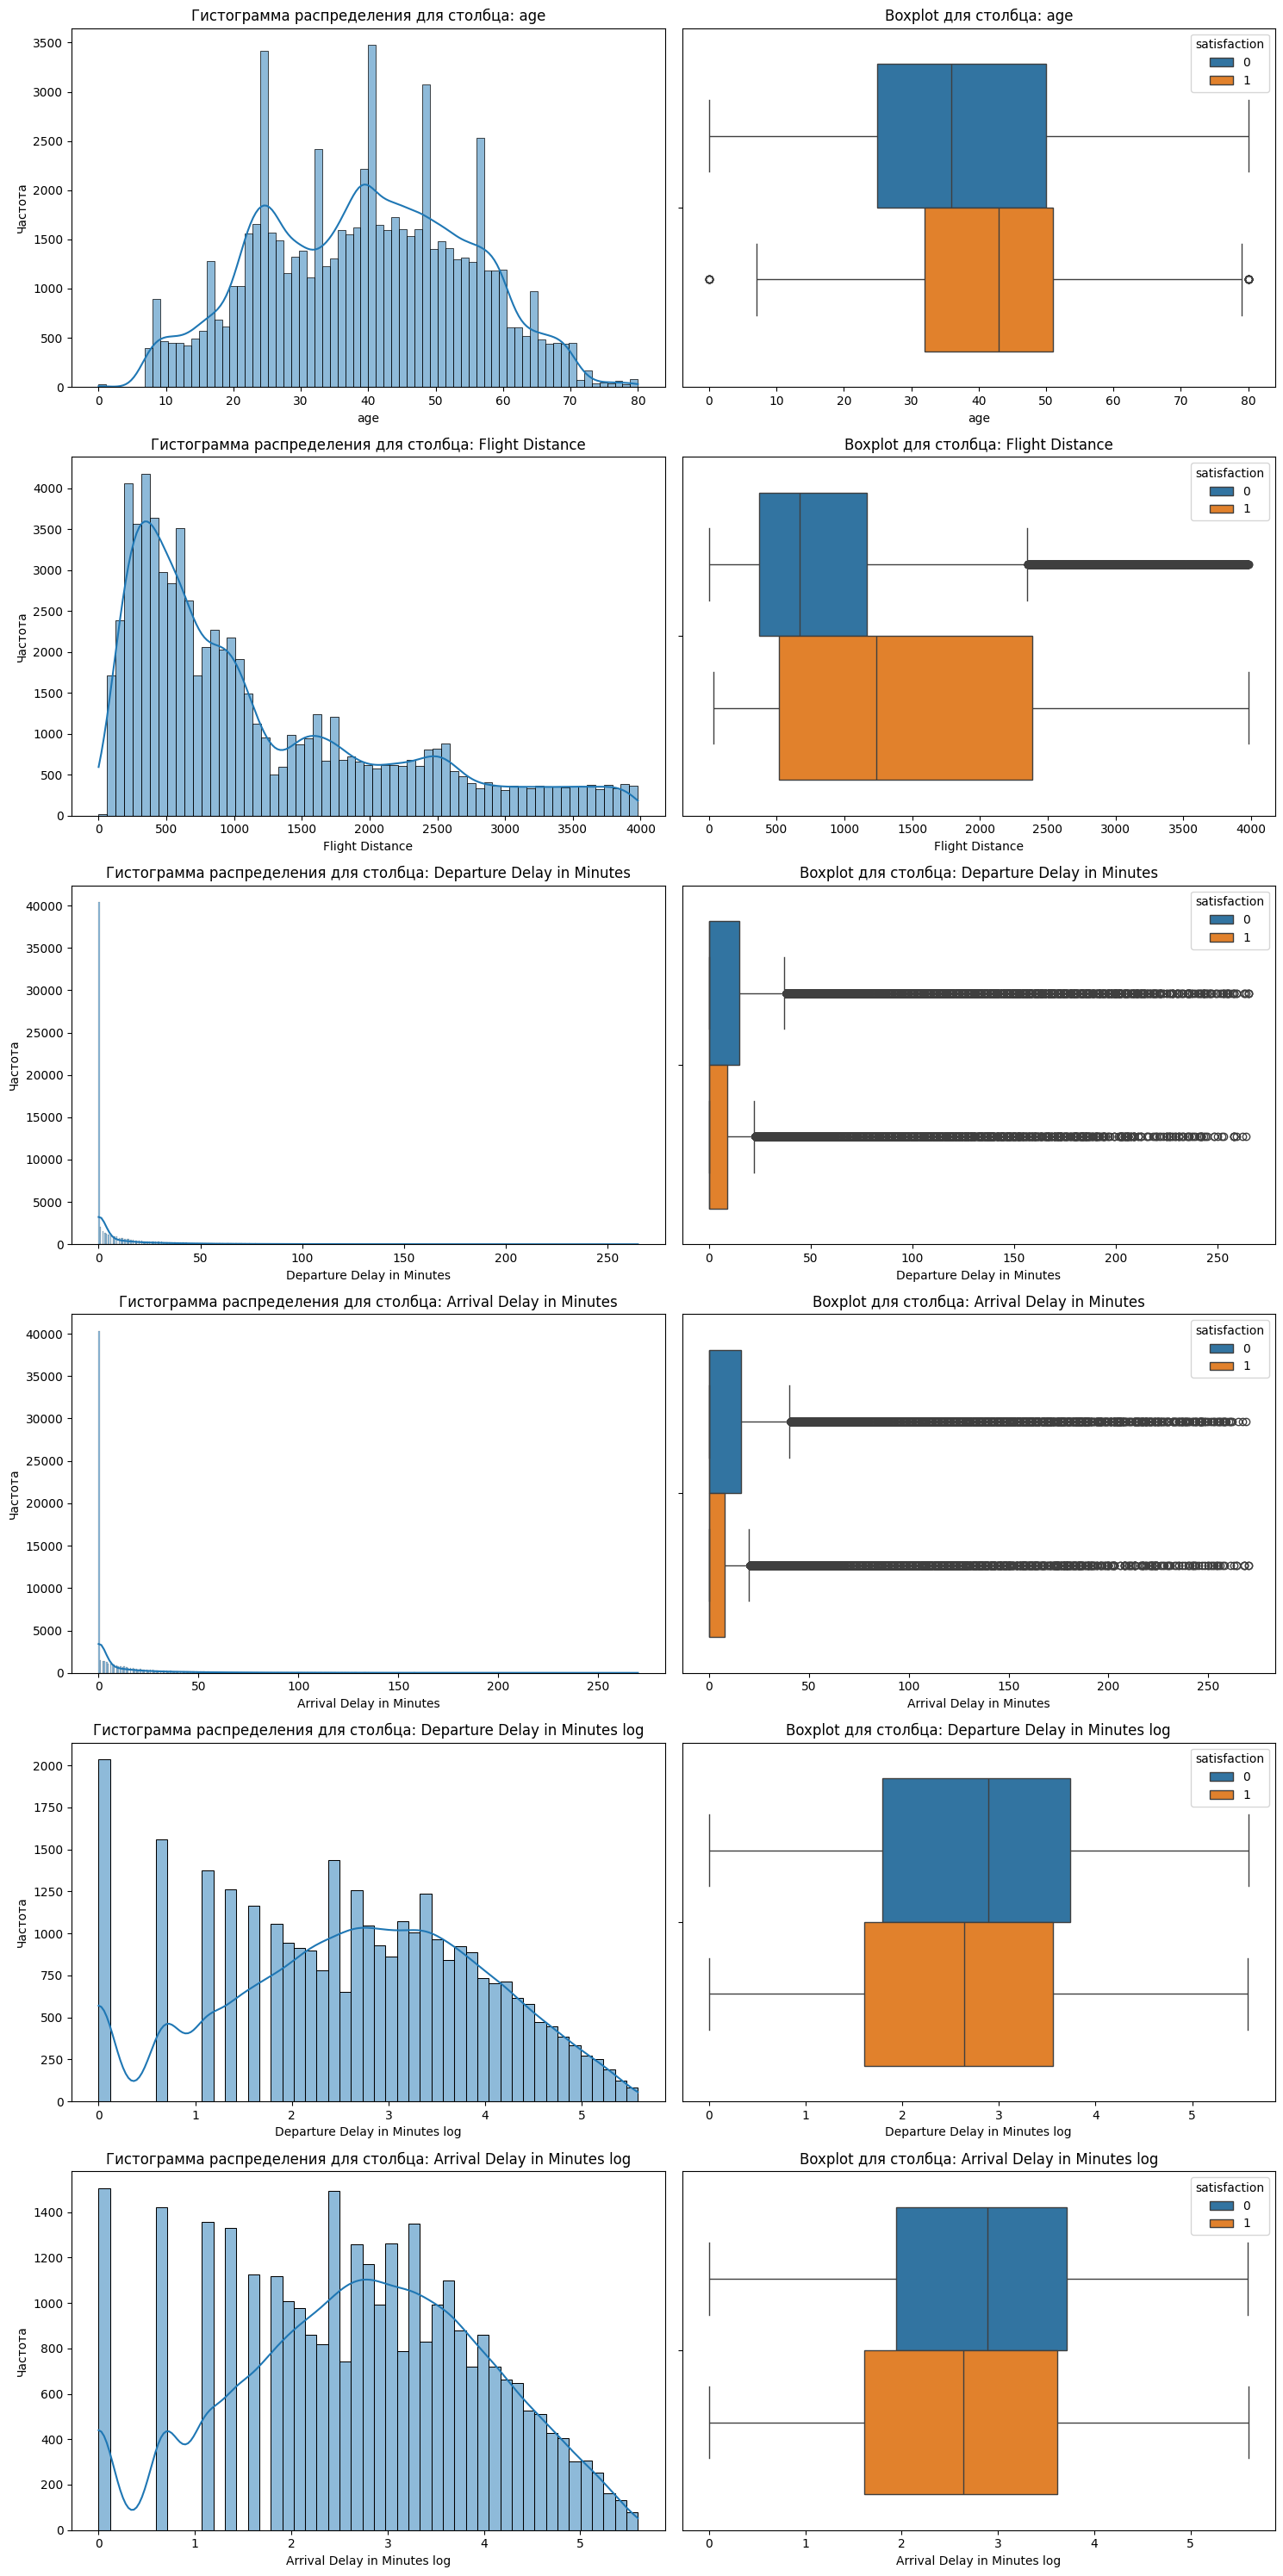

In [129]:
plot_continuous(continuous_cols, X_train_filtered_log, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [ ]:
def plot_scatterplots(columns, df, y):
    n = len(columns)
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(nrows=(n // 2) + (n % 2), ncols=2, figsize=(12, 6 * ((n // 2) + (n % 2))))
    axes = axes.flatten()
    
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j: 
                idx = (i * (n - 1)) + (j - 1)  # индекс графика
                sns.scatterplot(data=df, x=col1, y=col2, ax=axes[idx], hue=y)
                axes[idx].set_title(f'{col1} vs {col2}')
    
    plt.tight_layout()
    plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

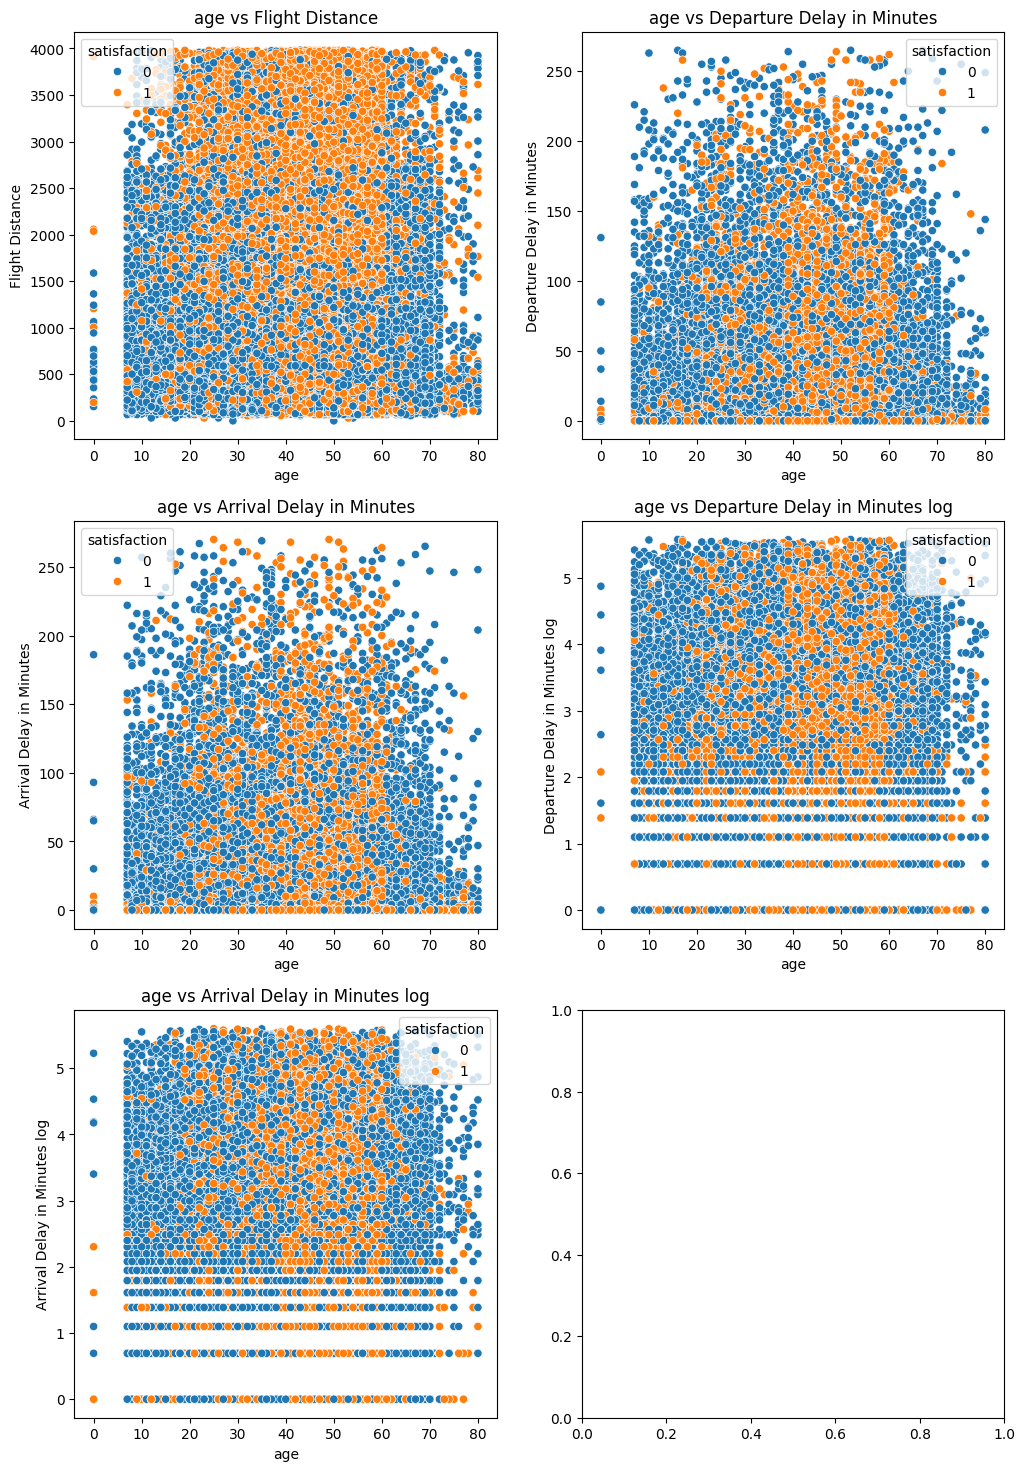

In [135]:
plot_scatterplots(continuous_cols, X_train_filtered_log, y_train)

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [55]:
# кодирование satisfied в треине и валидации
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [56]:
# уберем таргет из категоприальных колонок
X_categorical_cols = categorical_cols.copy()
X_categorical_cols.remove('satisfaction')

In [57]:
categorical_cols

['satisfaction', 'gender', 'Customer Type', 'Type of Travel', 'class']

In [58]:
X_categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

In [ ]:
# кодирование OHE у трэина
encoded_columns = pd.get_dummies(X_train_filtered[X_categorical_cols], prefix=X_categorical_cols, drop_first=True)

X_train_encoded = pd.concat([X_train_filtered, encoded_columns], axis=1)

X_train_encoded = X_train_encoded.drop(columns=X_categorical_cols)

In [60]:
X_train_encoded.head(3)

Inflight wifi service  Departure/Arrival time convenient  \
client_id                                                             
2031                         2.0                                2.0   
11597                        0.0                                0.0   
74668                        3.0                                1.0   

           Ease of Online booking  Gate location  Food and drink  \
client_id                                                          
2031                          2.0            4.0             4.0   
11597                         0.0            3.0             2.0   
74668                         3.0            2.0             5.0   

           Online boarding  Seat comfort  Inflight entertainment  \
client_id                                                          
2031                   2.0           3.0                     4.0   
11597                  2.0           1.0                     3.0   
74668                  3.0           5.0                     5.0   

           On-board service  Leg room service  ...  \
client_id                                      ...   
2031                    4.0               3.0  ...   
11597                   3.0               3.0  ...   
74668                   2.0               5.0  ...   

           Departure Delay in Minutes  Arrival Delay in Minutes  gender_Male  \
client_id                                                                      
2031                              0.0                       0.0        False   
11597                             0.0                       0.0        False   
74668                             0.0                       0.0         True   

           Customer Type_disloyal Customer  Customer Type_nan  \
client_id                                                       
2031                                  True              False   
11597                                False              False   
74668                                False              False   

           Type of Travel_Personal Travel  Type of Travel_nan  class_Eco  \
client_id                                                                  
2031                                False               False      False   
11597                               False               False      False   
74668                                True               False       True   

           class_Eco Plus  class_nan  
client_id                             
2031                False      False  
11597               False      False  
74668               False      False  

[3 rows x 26 columns]

In [ ]:
# кодирование OHE у теста
encoded_columns_val = pd.get_dummies(X_val_filtered[X_categorical_cols], prefix=X_categorical_cols, drop_first=True)

X_val_encoded = pd.concat([X_val_filtered, encoded_columns_val], axis=1)

X_val_encoded = X_val_encoded.drop(columns=X_categorical_cols)

In [62]:
X_val_encoded.head(3)

Inflight wifi service  Departure/Arrival time convenient  \
client_id                                                             
62191                        3.0                                3.0   
71183                        5.0                                5.0   
128411                       2.0                                1.0   

           Ease of Online booking  Gate location  Food and drink  \
client_id                                                          
62191                         3.0            3.0             1.0   
71183                         1.0            5.0             4.0   
128411                        2.0            3.0             2.0   

           Online boarding  Seat comfort  Inflight entertainment  \
client_id                                                          
62191                  4.0           1.0                     4.0   
71183                  4.0           4.0                     4.0   
128411                 2.0           2.0                     2.0   

           On-board service  Leg room service  ...  \
client_id                                      ...   
62191                   4.0               4.0  ...   
71183                   4.0               4.0  ...   
128411                  4.0               4.0  ...   

           Departure Delay in Minutes  Arrival Delay in Minutes  gender_Male  \
client_id                                                                      
62191                             0.0                       0.0         True   
71183                             0.0                       0.0         True   
128411                           52.0                      47.0         True   

           Customer Type_disloyal Customer  Customer Type_nan  \
client_id                                                       
62191                                False              False   
71183                                False              False   
128411                                True              False   

           Type of Travel_Personal Travel  Type of Travel_nan  class_Eco  \
client_id                                                                  
62191                               False               False      False   
71183                               False               False      False   
128411                              False               False       True   

           class_Eco Plus  class_nan  
client_id                             
62191               False      False  
71183               False      False  
128411              False      False  

[3 rows x 26 columns]

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [63]:
# Ваш код ниже
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [66]:
# чистка y_train от выбросных записей по X_train с помощью фильтрации по client_id
y_train = y_train.loc[X_train_encoded.index]

In [70]:
# чистка y_val от выбросных записей по X_val с помощью фильтрации по client_id
y_val = y_val.loc[X_val_encoded.index]

In [ ]:
model = DecisionTreeClassifier(random_state=42)

model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_val_encoded)

accuracy = accuracy_score(y_val, y_pred)

In [72]:
# accuracy
round(accuracy, 3)

0.943

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model,
                                                 X_train_encoded.values, y_train.values, X_val_encoded.values, y_val.values,
                                                 loss='0-1_loss',
                                                 random_seed=42)
error_dt, bias_dt, var_dt

(0.06142419525765001, 0.04023711749900649, 0.045755563650814686)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
model.get_depth()  # Глубина дерева

31

In [ ]:
# кол-во листьев
model.get_n_leaves()

2100

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_1121/2512899931.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


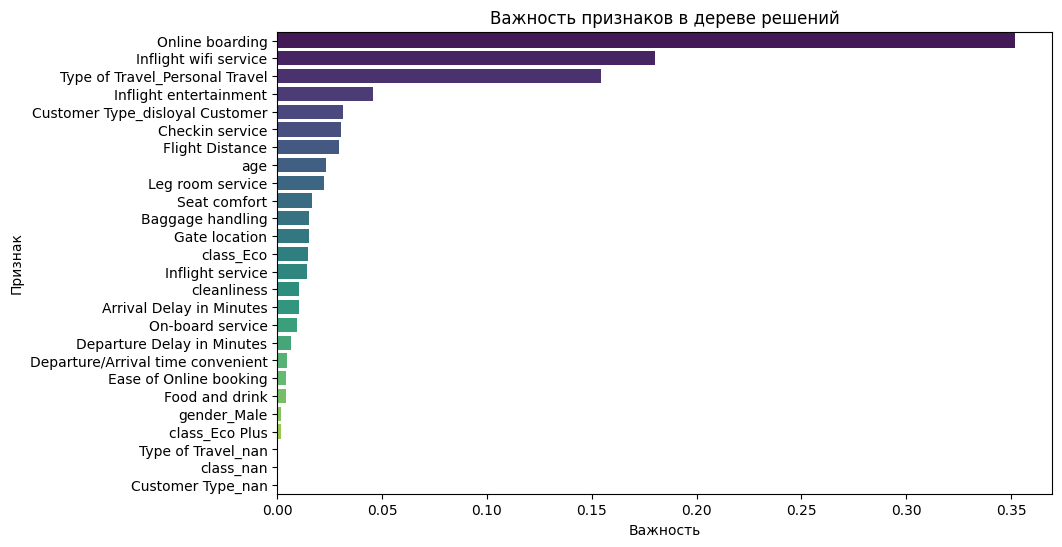

In [ ]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Самыми значимыми признаками стали:


1.   Online boarding
2.   Inflight wifi service
3.   Type of travel resonal travel



### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [77]:
top_2_features = list(importance_df.iloc[:2]['Feature'].values)

In [78]:
top_2_features

['Online boarding', 'Inflight wifi service']

In [ ]:
model_2 = DecisionTreeClassifier(max_depth=5, random_state=42)

model_2.fit(X_train_encoded[top_2_features], y_train)

y_pred = model_2.predict(X_val_encoded[top_2_features])

# Вычисляем accuracy_score
accuracy = accuracy_score(y_val, y_pred)
round(accuracy, 3)

0.825

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [151]:
import graphviz

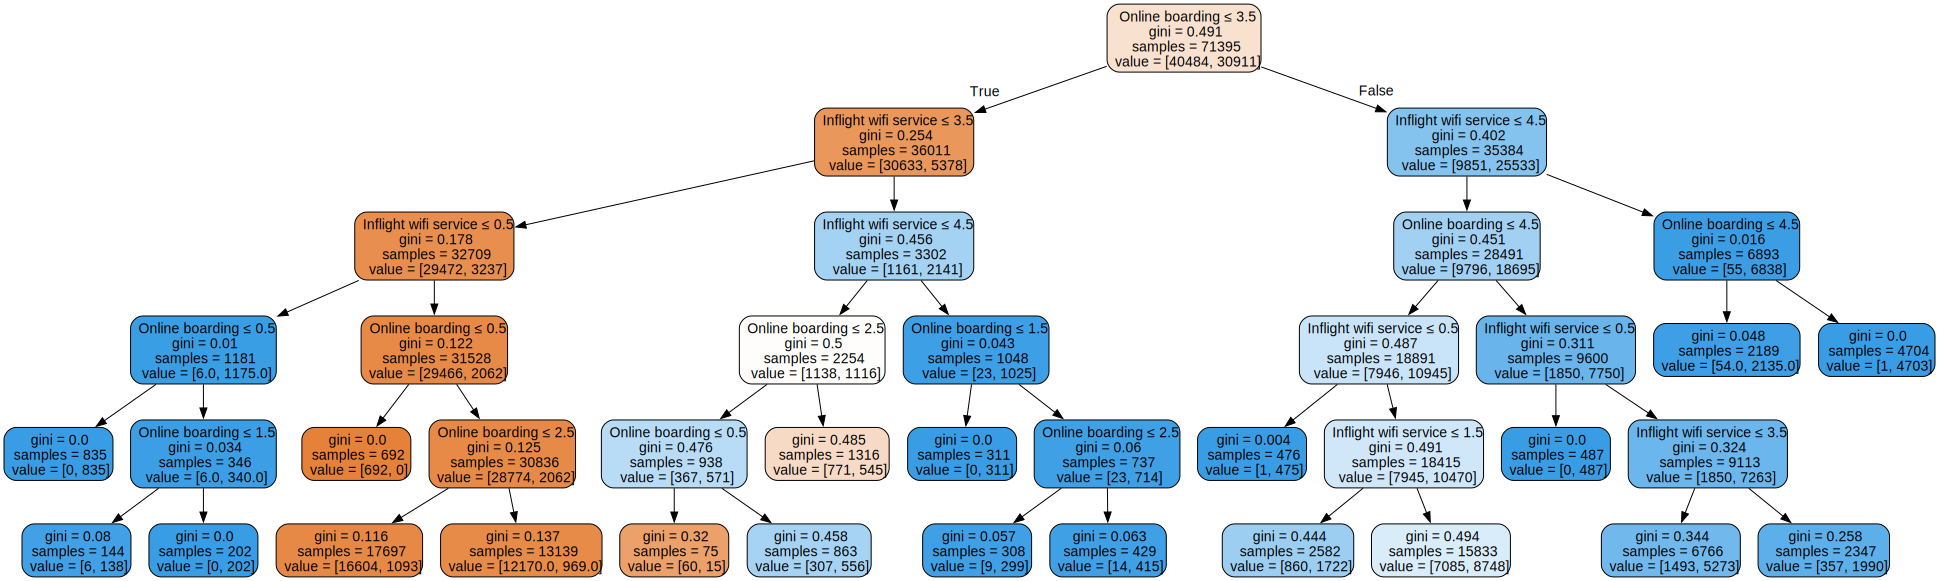

In [ ]:
dot_data = export_graphviz(
    model_2,
    out_file=None,
    feature_names=X_train_encoded[top_2_features].columns,
    filled=True,                     
    rounded=True,                     
    special_characters=True           
)

graph = graphviz.Source(dot_data)
graph

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

In [ ]:
from sklearn import plot_tree

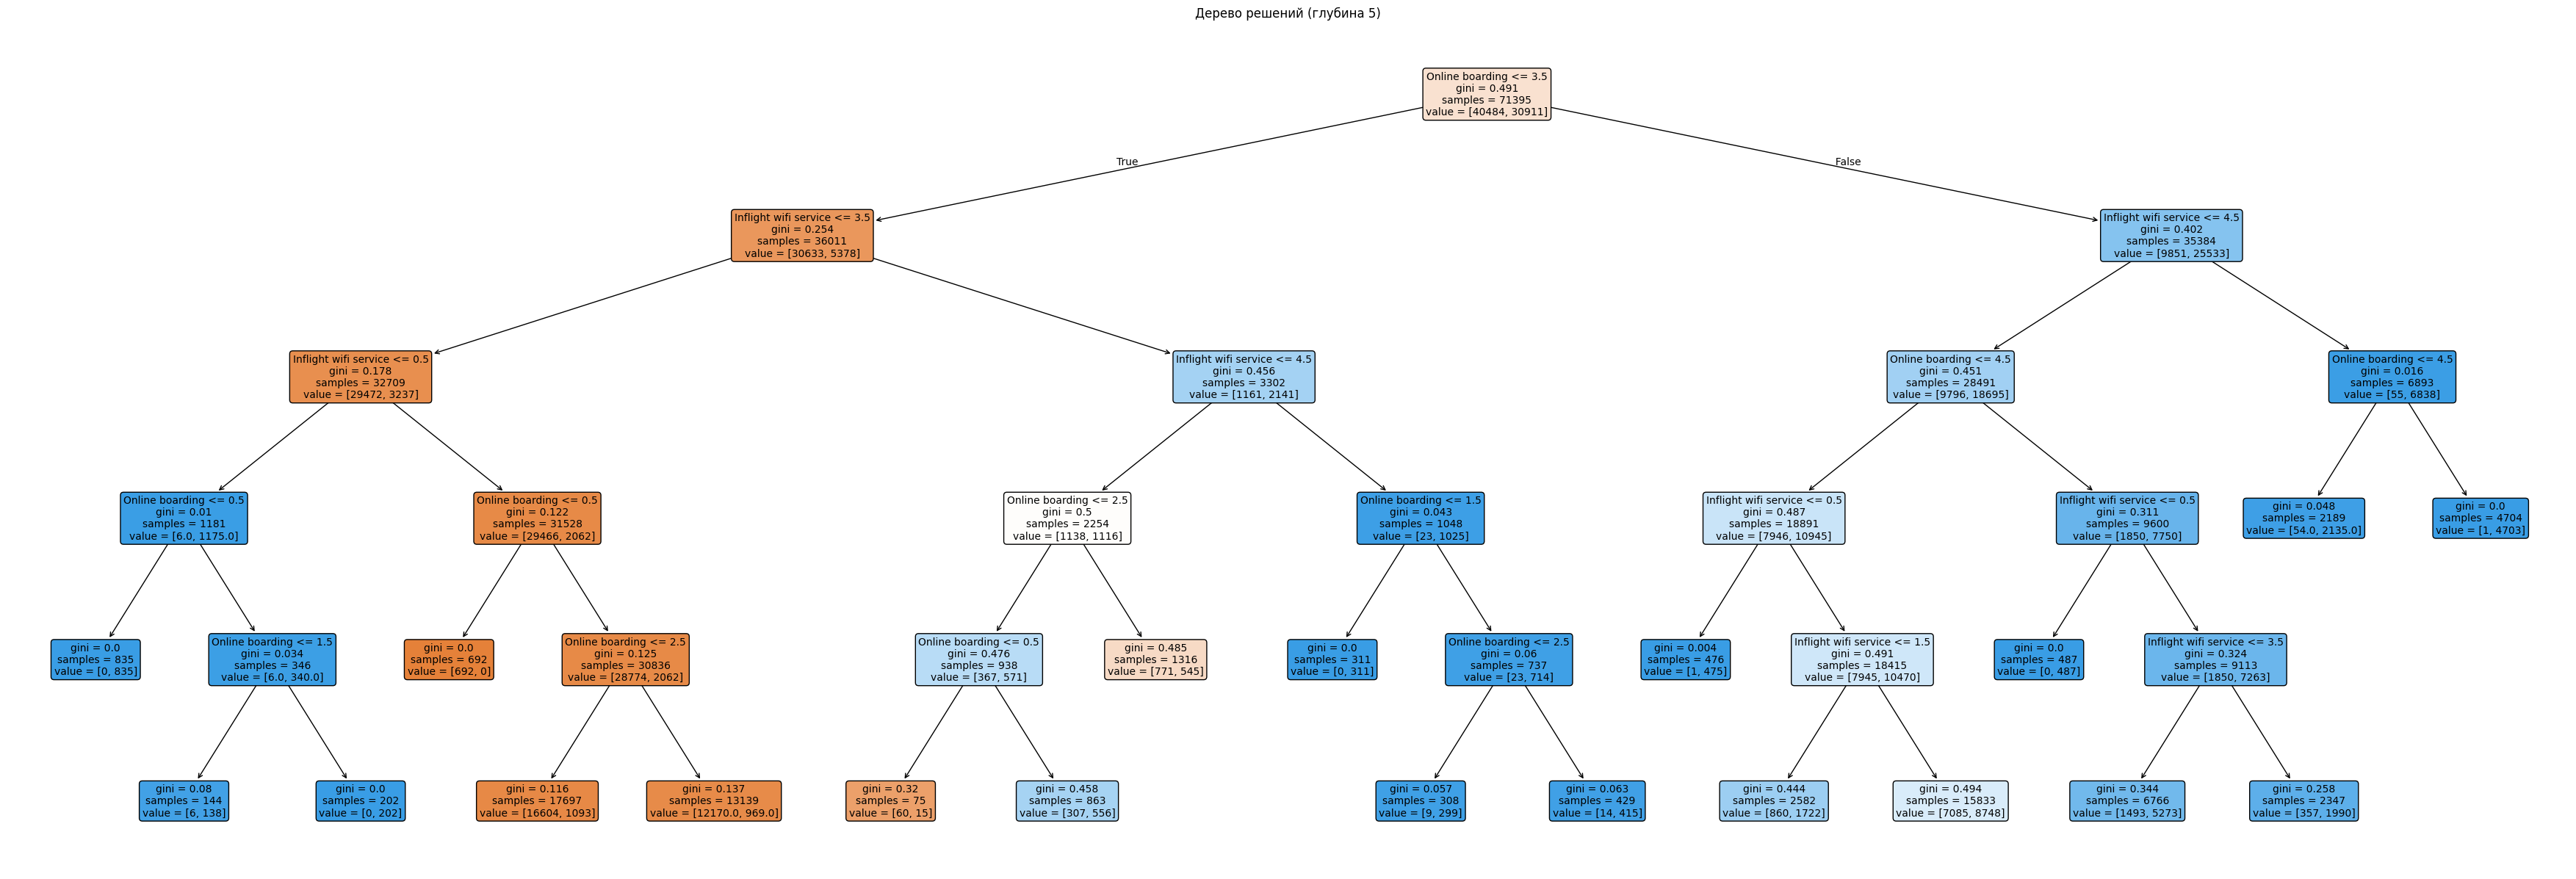

In [ ]:
plt.figure(figsize=(45, 15))
plot_tree(
    model_2,
    feature_names=X_train_encoded[top_2_features].columns,
    filled=True,                 
    rounded=True,                
    fontsize=10                    
)
plt.title("Дерево решений (глубина 5)")
plt.show()

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


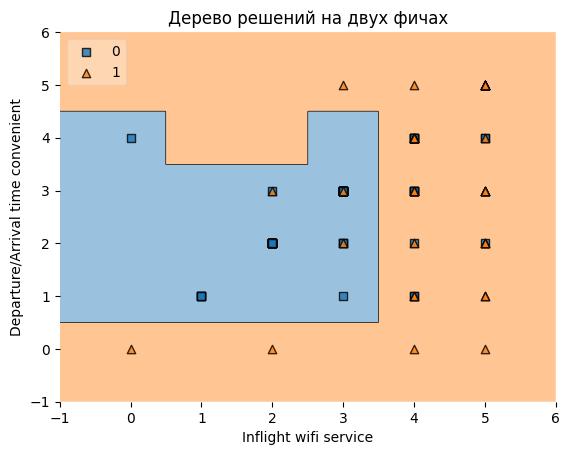

In [199]:
# Ваш код здесь
plot_decision_regions(
    X_train_encoded[top_2_features][:100].to_numpy(),
    y_train[:100].values, 
    clf=model_2,   
    legend=2   
)

# Добавляем подписи
plt.xlabel(X_train_encoded.columns[0])
plt.ylabel(X_train_encoded.columns[1])
plt.title("Дерево решений на двух фичах")
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [181]:
# # замените X_train_example на вашу переменную

# fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# for row in range(3):
#     for col in range(3):
#         inds = np.random.choice(X_train_encoded.index, size=X_train_encoded.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

#         tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
#         tree_exp.fit(X_train_encoded.loc[inds, :], y_train[inds])

#         plot_decision_regions(clf=tree_exp, X=np.array(X_train_encoded.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [87]:
import time

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)
# По времени, 2,3 секунды на локальной машине
# %%time

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_encoded, y_train)
    y_predicted_train = DT.predict(X_train_encoded)
    y_predicted_val = DT.predict(X_val_encoded)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

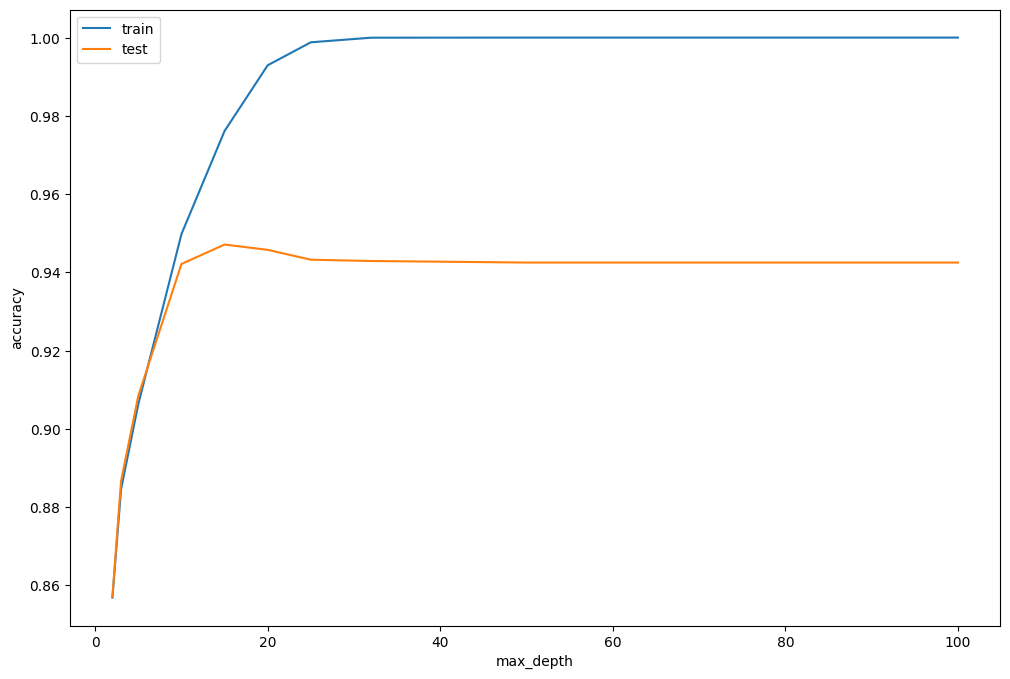

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do
param_grid = {
    'max_depth': [5, 7, 9, 15, 20, None],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',  
    n_jobs=-1 
)

grid_search.fit(X_train_encoded, y_train)

print("Лучшие параметры:", grid_search.best_params_)

y_pred = grid_search.predict(X_val_encoded)
# accuracy
accuracy = accuracy_score(y_val, y_pred)

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [93]:
# было 0,942 - качество удалось улучшить
round(accuracy, 3)

0.951

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [94]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
model_3 = RandomForestClassifier(random_state=42)

model_3.fit(X_train_encoded, y_train)

y_pred = model_3.predict(X_val_encoded)

accuracy = accuracy_score(y_val, y_pred)
round(accuracy, 3)

0.961

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [96]:
from sklearn.calibration import calibration_curve

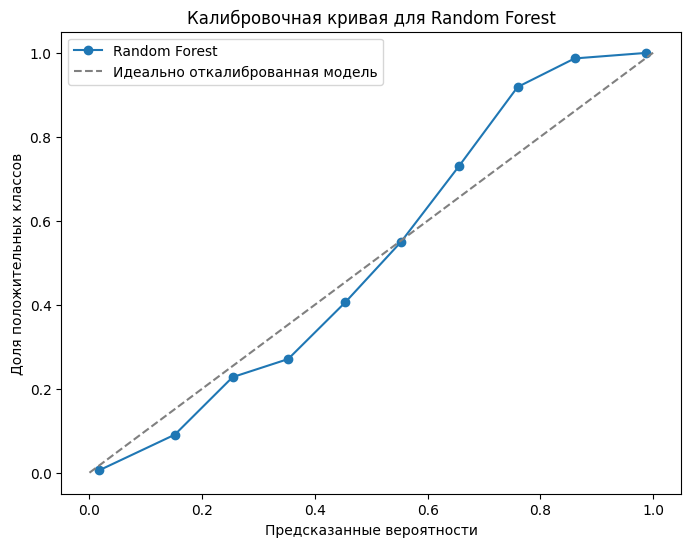

In [ ]:
prob_rfc = model_3.predict_proba(X_val_encoded)[:, 1]

true_prob, pred_prob = calibration_curve(y_val, prob_rfc, n_bins=10)

# калибровочная кривая
plt.figure(figsize=(8, 6))
plt.plot(pred_prob, true_prob, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеально откалиброванная модель', color='gray')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочная кривая для Random Forest')
plt.legend()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Истинную вероятность дает только logreg
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


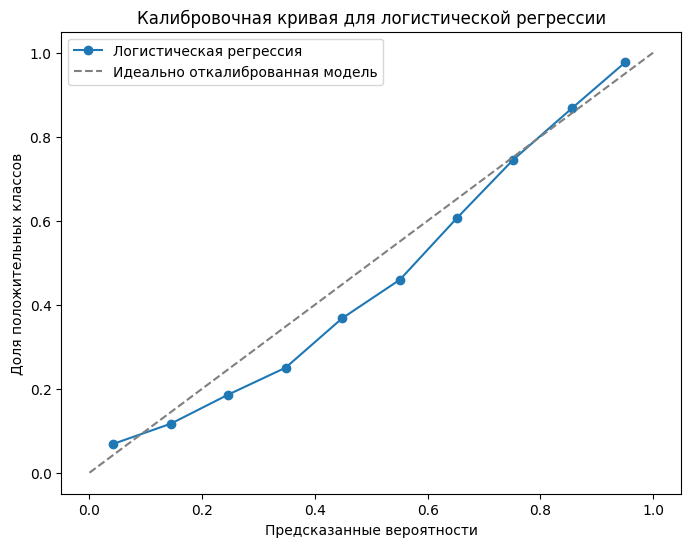

In [ ]:
model_logreg = LogisticRegression(max_iter=1000, random_state=42)

model_logreg.fit(X_train_encoded, y_train)

prob_logreg = model_logreg.predict_proba(X_val_encoded)[:, 1]

# калибровочную кривая
true_prob, pred_prob = calibration_curve(y_val, prob_logreg, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(pred_prob, true_prob, marker='o', label='Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеально откалиброванная модель', color='gray')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочная кривая для логистической регрессии')
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [99]:
from sklearn.metrics import brier_score_loss

In [100]:
# Ваш код здесь (Logreg)
lr = LogisticRegression()
lr.fit(prob_rfc.reshape(-1, 1), y_val)
lr_probs = lr.predict_proba(prob_rfc.reshape(-1, 1))[:, 1]

In [101]:
# Ваш код здесь (isoreg)
ir = IsotonicRegression()
ir.fit(prob_rfc, y_val)
ir_probs = ir.predict(prob_rfc)

In [102]:
# Оценка качества калибровки
rf_brier = brier_score_loss(y_val, prob_rfc)
lr_brier = brier_score_loss(y_val, lr_probs)
ir_brier = brier_score_loss(y_val, ir_probs)

In [103]:
rf_brier, lr_brier, ir_brier

(0.029918684593985955, 0.029503174276857495, 0.028060210820408316)

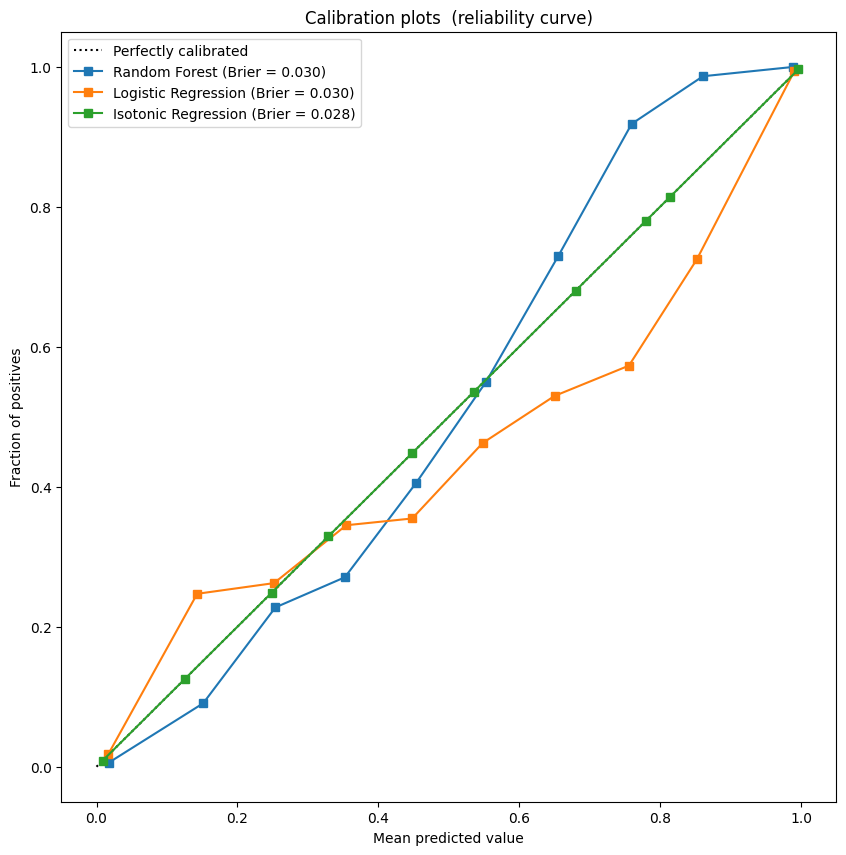

In [104]:
# Визуализация калибровочных кривых
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_rfc, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Random Forest (Brier = {rf_brier:.3f})")

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, lr_probs, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Logistic Regression (Brier = {lr_brier:.3f})")

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, ir_probs, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Isotonic Regression (Brier = {ir_brier:.3f})")

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration plots  (reliability curve)")
plt.legend()
plt.show()

Изотоническая регрессия лучше всех откалибровала вероятности

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_3,
                                                 X_train_encoded.values, y_train.values, X_val_encoded.values, y_val.values,
                                                 loss='0-1_loss',
                                                 random_seed=42)
error_dt, bias_dt, var_dt

(0.040256656510796136, 0.038779970857067164, 0.009103523645515962)


```
Отличия от Decision Tree - очень сильно снизилась дисперсия
Соответствуют ли результаты ожиданиям? Да, соответсвует
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(model_logreg,
                                                 X_train_encoded.values, y_train.values, X_val_encoded.values, y_val.values,
                                                 loss='0-1_loss',
                                                 random_seed=42)
error_dt, bias_dt, var_dt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

(0.1319790700755067, 0.1319380050337793, 0.010382832163200423)

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [107]:
from scipy.stats import uniform, randint

In [155]:
param_distributions = {
    'n_estimators': randint(100, 500), 
    'max_depth': randint(1, 20),   
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),  
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False],  
    'criterion': ['gini', 'entropy'], 
    'max_samples': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    estimator=model_3,
    param_distributions=param_distributions,
    n_iter=100, 
    cv=5,       
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_encoded, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x377983a40>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x37799a1e0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x37799a8a0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3285b5190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3779810d0>},
                   random_state=42, scoring='accuracy')

In [156]:
# лучшие параметры
random_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 17,
 'max_features': None,
 'max_samples': 0.9538468531742732,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 169}

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [109]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_encoded[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimat

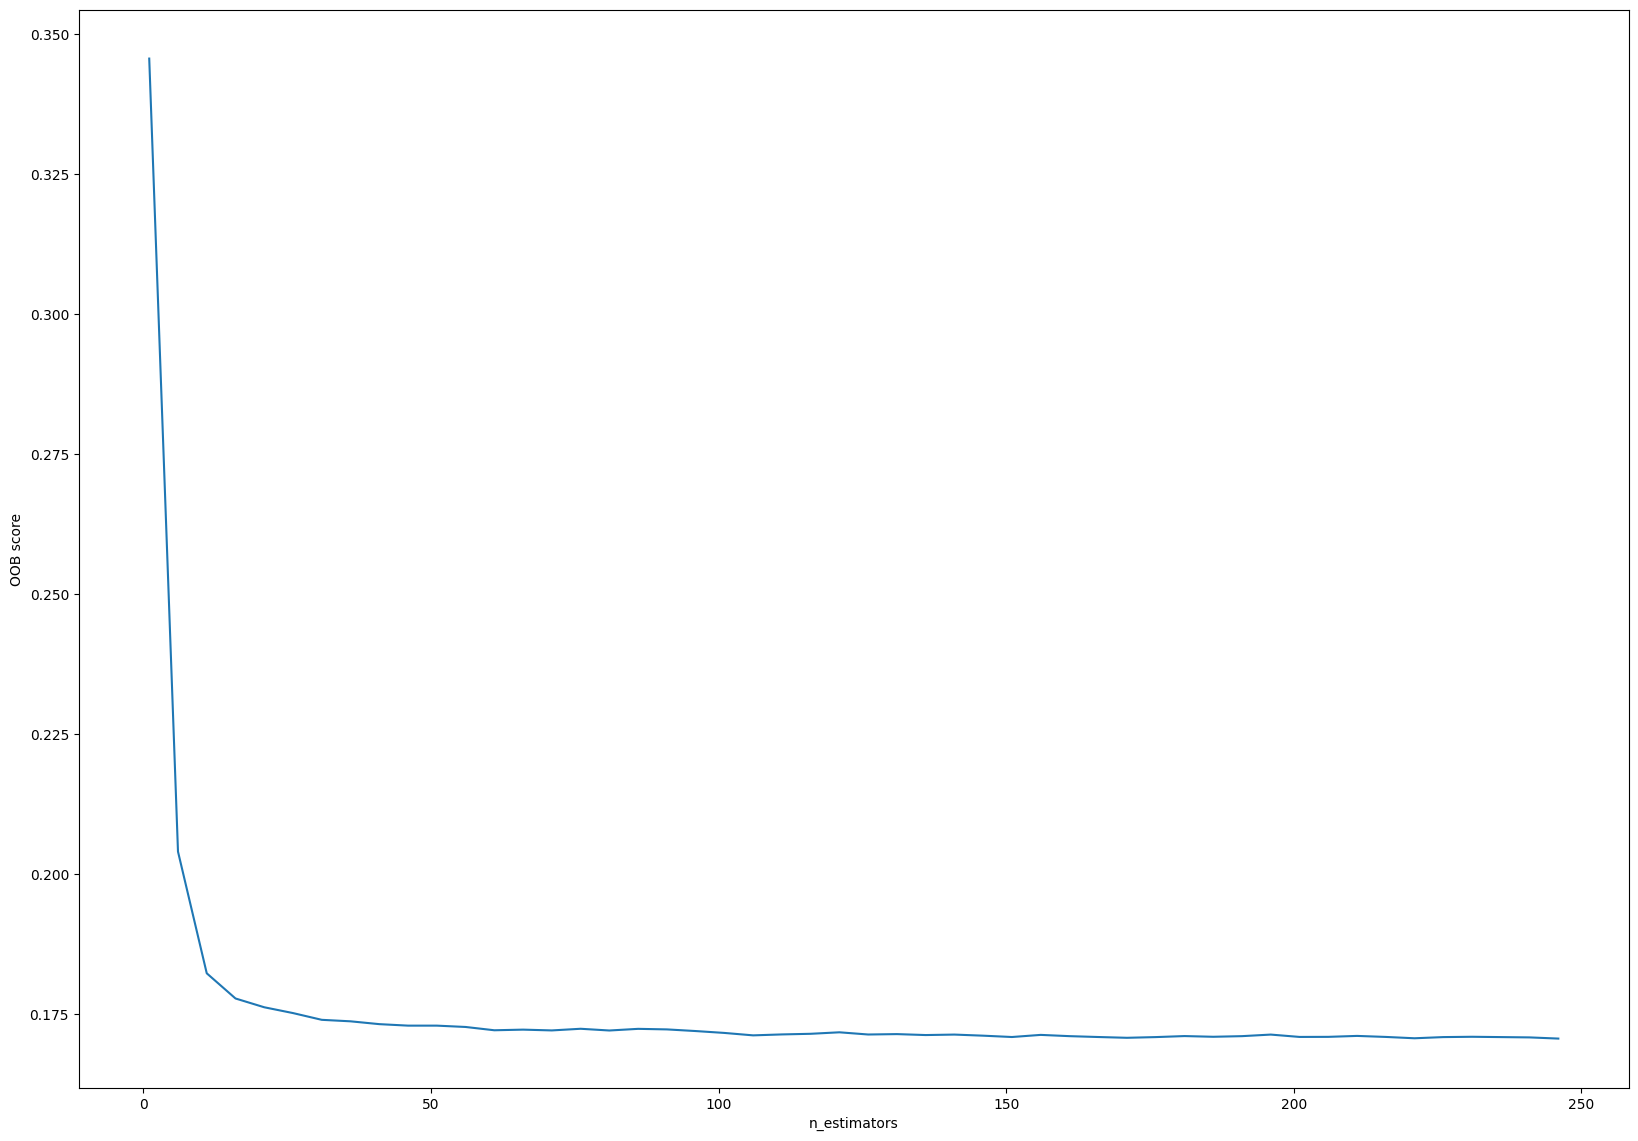

In [110]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [111]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 17,
 'max_features': None,
 'max_samples': 0.9538468531742732,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 169}

In [112]:
best_model = random_search.best_estimator_
feature_importances = best_model.feature_importances_

/var/folders/b5/7wyqv1652bj52cb4jlgfcldc0000gr/T/ipykernel_1121/2266210603.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


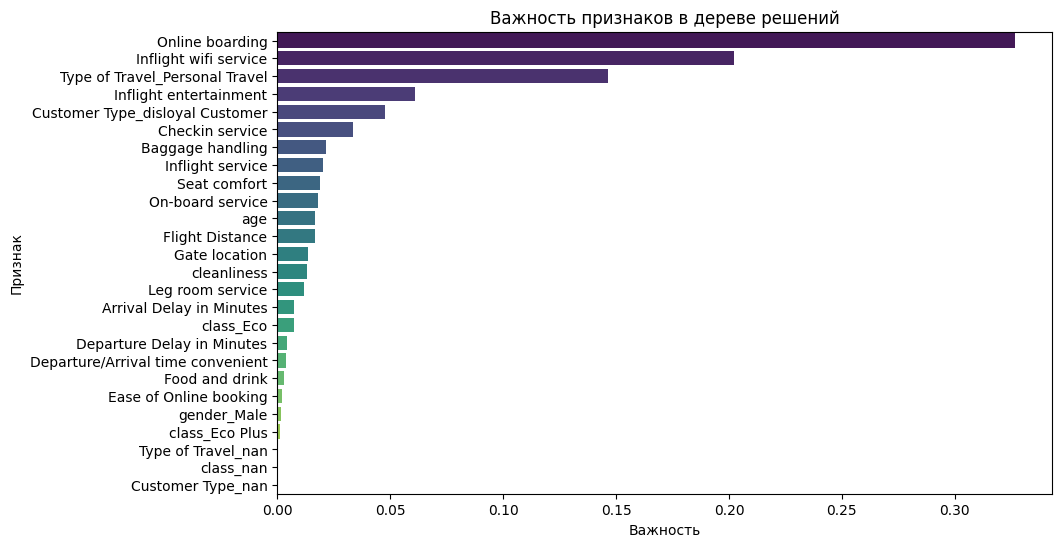

In [ ]:
# df
importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в decision tree')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [114]:
with open('RFC.pkl', 'wb') as f:
    pickle.dump(random_search, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [157]:
import shap

In [159]:
X_sample

Inflight wifi service  Departure/Arrival time convenient  \
client_id                                                             
21725                        4.0                                4.0   
10820                        3.0                                1.0   
77204                        4.0                                2.0   
45734                        3.0                                5.0   
24064                        4.0                                5.0   
...                          ...                                ...   
100473                       1.0                                1.0   
116379                       4.0                                5.0   
7340                         3.0                                1.0   
41253                        0.0                                5.0   
1880                         4.0                                4.0   

           Ease of Online booking  Gate location  Food and drink  \
client_id                                                          
21725                         4.0            4.0             2.0   
10820                         3.0            3.0             2.0   
77204                         2.0            2.0             4.0   
45734                         4.0            3.0             4.0   
24064                         5.0            5.0             4.0   
...                           ...            ...             ...   
100473                        1.0            3.0             3.0   
116379                        4.0            4.0             2.0   
7340                          1.0            1.0             3.0   
41253                         0.0            4.0             3.0   
1880                          3.0            1.0             5.0   

           Online boarding  Seat comfort  Inflight entertainment  \
client_id                                                          
21725                  4.0           5.0                     4.0   
10820                  3.0           2.0                     2.0   
77204                  4.0           4.0                     2.0   
45734                  3.0           4.0                     3.0   
24064                  4.0           4.0                     4.0   
...                    ...           ...                     ...   
100473                 1.0           3.0                     3.0   
116379                 4.0           1.0                     2.0   
7340                   3.0           3.0                     3.0   
41253                  0.0           3.0                     3.0   
1880                   3.0           5.0                     5.0   

           On-board service  Leg room service  ...  \
client_id                                      ...   
21725                   4.0               4.0  ...   
10820                   1.0               4.0  ...   
77204                   3.0               4.0  ...   
45734                   3.0               4.0  ...   
24064                   5.0               3.0  ...   
...                     ...               ...  ...   
100473                  4.0               2.0  ...   
116379                  4.0               3.0  ...   
7340                    3.0               3.0  ...   
41253                   1.0               2.0  ...   
1880                    5.0               2.0  ...   

           Departure Delay in Minutes  Arrival Delay in Minutes  gender_Male  \
client_id                                                                      
21725                             0.0                       0.0        False   
10820                             2.0                       5.0        False   
77204                             0.0                       0.0        False   
45734                            10.0                       0.0        False   
24064                             7.0                      14.0         True   
...                               ...                 

In [ ]:
import shap

# Инициализируем объяснитель SHAP
explainer = shap.TreeExplainer(model)

# Вычисляем значения SHAP для тестовой выборки
shap_values = explainer.shap_values(X_test)

In [163]:
X_sample.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'cleanliness', 'age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'gender_Male',
       'Customer Type_disloyal Customer', 'Customer Type_nan',
       'Type of Travel_Personal Travel', 'Type of Travel_nan', 'class_Eco',
       'class_Eco Plus', 'class_nan'],
      dtype='object')

In [174]:
X_sample.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'cleanliness', 'age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'gender_Male',
       'Customer Type_disloyal Customer', 'Customer Type_nan',
       'Type of Travel_Personal Travel', 'Type of Travel_nan', 'class_Eco',
       'class_Eco Plus', 'class_nan'],
      dtype='object')

ValueError: too many values to unpack (expected 2)

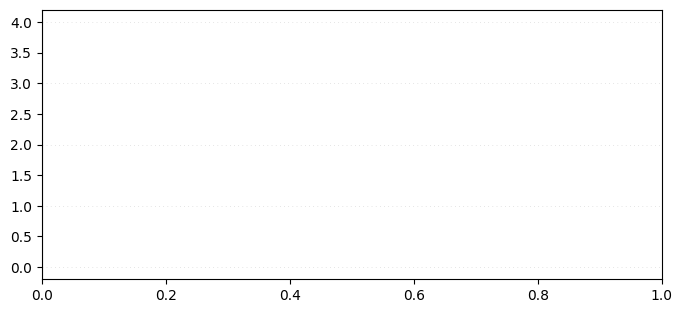

In [ ]:
# Не понимаю, как пофиксить
X_sample = X_val_encoded.sample(n=1000, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

shap.plots.violin(shap_values, X_sample, feature_names=X_sample.columns, max_display=5)

`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [175]:
import lime
import lime.lime_tabular

In [178]:
# Создаем объяснитель LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_encoded.values,  # Обучающие данные
    feature_names=X_train_encoded.columns,  # Названия признаков
    class_names=y_train.values,  # Названия классов
    mode='classification'  # Режим (классификация или регрессия)
)

In [182]:
i=30
exp = explainer.explain_instance(X_val_encoded.iloc[i].values, best_model.predict_proba, num_features=5)

exp.as_list()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('Type of Travel_Personal Travel <= 0.00', 0.46706156706420526),
 ('Customer Type_disloyal Customer <= 0.00', 0.31815886287169926),
 ('Inflight wifi service <= 2.00', -0.09783392818052487),
 ('Online boarding <= 2.00', -0.09191734259749348),
 ('Inflight service <= 3.00', -0.04985435325320319)]

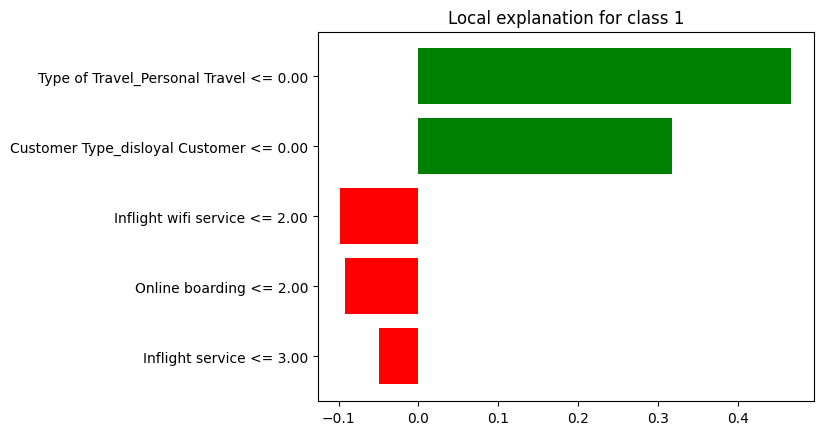

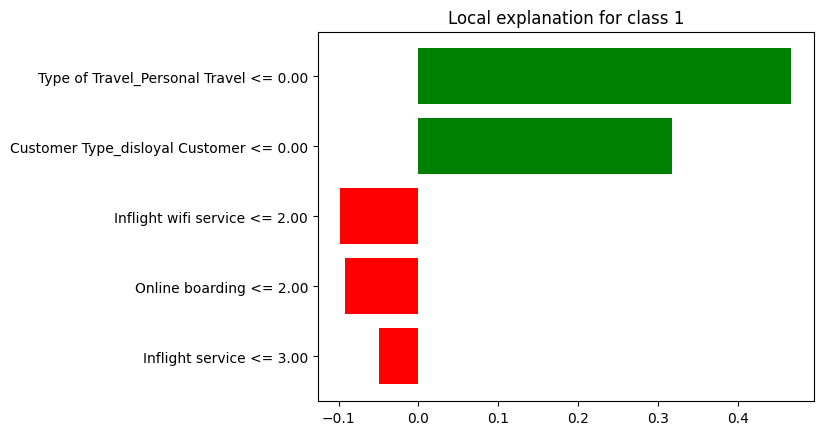

In [185]:
exp.as_pyplot_figure()

`наибольшее значение имеют признаки тип поездки и тип клиента (влияние положительное)`
`важное отрицательное влияние оказывают оценка wifi сервиса, оценка онлайн бронирования и оценка сервиса во врея полета`

## Котобонус!

0.25 балла

Елены)

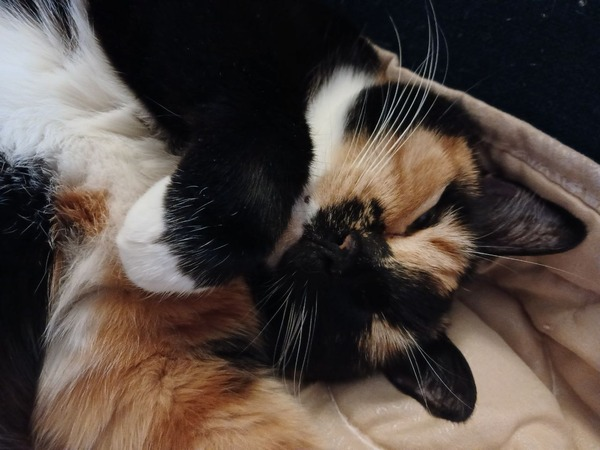

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?